# 1 初始化

## 1.1 导入包

In [1]:
import lightgbm as lgb
import numpy as np
import os
import pandas as pd
import pickle
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from lightgbm import LGBMClassifier
from tqdm import tqdm
import logging

log_fmt = "[%(asctime)s] %(levelname)s in %(module)s: %(message)s"
logging.basicConfig(format=log_fmt, level=logging.INFO)

import warnings
warnings.filterwarnings('ignore')

os.environ["CUDA_VISIBLE_DEVICES"] = "2, 3"

## 1.2 超参数定义

In [2]:
base_path = '/home/zengrui/datasets/190829_Kanshan_zjfx'

def save_param(param, param_name):
    with open(f'{base_path}/temp/{param_name}.txt', 'wb') as f:
        pickle.dump(param, f)
        
def read_param(param_name):
    with open(f'{base_path}/temp/{param_name}.txt', 'rb') as f:
        return pickle.load(f)

## 1.3 函数定义

In [3]:
def extract_day(s):
    return s.apply(lambda x: int(x.split('-')[0][1:]))


def extract_hour(s):
    return s.apply(lambda x: int(x.split('-')[1][1:]))

# 2 加载、处理数据

## 2.1 加载邀请回答数据

In [4]:
train = pd.read_csv(f'{base_path}/invite_info_0926.txt', sep='\t', header=None)
train.columns = ['qid', 'uid', 'dt', 'label']
logging.info("invite %s", train.shape)

test = pd.read_csv(f'{base_path}/invite_info_evaluate_1_0926.txt', sep='\t', header=None)
test.columns = ['qid', 'uid', 'dt']
logging.info("test %s", test.shape)

sub = test.copy()

sub_size = len(sub)

train['day'] = extract_day(train['dt'])
train['hour'] = extract_hour(train['dt'])

test['day'] = extract_day(test['dt'])
test['hour'] = extract_hour(test['dt'])

del train['dt'], test['dt']

[2019-12-09 08:38:40,642] INFO in <ipython-input-4-7a2c6478cb9e>: invite (9489162, 4)
[2019-12-09 08:38:41,753] INFO in <ipython-input-4-7a2c6478cb9e>: test (1141683, 3)


## 2.2 加载问题

丢弃了**问题info**的字词编码。

In [5]:
ques = pd.read_csv(f'{base_path}/question_info_0926.txt', header=None, sep='\t')
ques.columns = ['qid', 'q_dt', 'title_t1', 'title_t2', 'desc_t1', 'desc_t2', 'topic']
del ques['title_t1'], ques['title_t2'], ques['desc_t1'], ques['desc_t2']
logging.info("ques %s", ques.shape)

ques['q_day'] = extract_day(ques['q_dt'])
ques['q_hour'] = extract_hour(ques['q_dt'])
del ques['q_dt']

[2019-12-09 08:39:11,860] INFO in <ipython-input-5-958902b92fc5>: ques (1829900, 3)


## 2.3 加载回答

丢弃了**回答info**的字词编码，并与**问题info**合并。

In [6]:
ans = pd.read_csv(f'{base_path}/answer_info_0926.txt', header=None, sep='\t')
ans.columns = ['aid', 'qid', 'uid', 'ans_dt', 'ans_t1', 'ans_t2', 'is_good', 'is_rec', 'is_dest', 'has_img',
               'has_video', 'word_count', 'reci_cheer', 'reci_uncheer', 'reci_comment', 'reci_mark', 'reci_tks',
               'reci_xxx', 'reci_no_help', 'reci_dis']
del ans['ans_t1'], ans['ans_t2']
logging.info("ans %s", ans.shape)

ans['a_day'] = extract_day(ans['ans_dt'])
ans['a_hour'] = extract_hour(ans['ans_dt'])
del ans['ans_dt']

ans = pd.merge(ans, ques, on='qid')
del ques

[2019-12-09 08:40:20,275] INFO in <ipython-input-6-935311f5f359>: ans (4513735, 18)


## 2.4 处理时间数据

回答距提问的天数。

In [7]:
ans['diff_qa_days'] = ans['a_day'] - ans['q_day']

时间窗口划分。

In [8]:
train_start = 3838
train_end = 3867

val_start = 3868
val_end = 3874

label_end = 3867
label_start = label_end - 6

train_label_feature_end = label_end - 7
train_label_feature_start = train_label_feature_end - 22

train_ans_feature_end = label_end - 7
train_ans_feature_start = train_ans_feature_end - 50

val_label_feature_end = val_start - 1
val_label_feature_start = val_label_feature_end - 22

val_ans_feature_end = val_start - 1
val_ans_feature_start = val_ans_feature_end - 50

train_label_feature = train[(train['day'] >= train_label_feature_start) & (train['day'] <= train_label_feature_end)]
logging.info("train_label_feature %s", train_label_feature.shape)

val_label_feature = train[(train['day'] >= val_label_feature_start) & (train['day'] <= val_label_feature_end)]
logging.info("val_label_feature %s", val_label_feature.shape)

train_label = train[(train['day'] > train_label_feature_end)]

logging.info("train feature start %s end %s, label start %s end %s", train_label_feature['day'].min(),
             train_label_feature['day'].max(), train_label['day'].min(), train_label['day'].max())

logging.info("test feature start %s end %s, label start %s end %s", val_label_feature['day'].min(),
             val_label_feature['day'].max(), test['day'].min(), test['day'].max())

[2019-12-09 08:40:34,345] INFO in <ipython-input-8-5c7aac178bca>: train_label_feature (6895493, 5)
[2019-12-09 08:40:34,901] INFO in <ipython-input-8-5c7aac178bca>: val_label_feature (7583553, 5)
[2019-12-09 08:40:35,146] INFO in <ipython-input-8-5c7aac178bca>: train feature start 3838 end 3860, label start 3861 end 3867
[2019-12-09 08:40:35,173] INFO in <ipython-input-8-5c7aac178bca>: test feature start 3845 end 3867, label start 3868 end 3874


```python
print(train_label_feature_start, train_label_feature_end)
print(train_ans_feature_start, train_ans_feature_end)
print(val_label_feature_start, val_label_feature_end)
print(val_ans_feature_start, val_ans_feature_end)
```
```text
3838 3860
3810 3860
3845 3867
3817 3867
```

确定ans的时间范围。

In [9]:
train_ans_feature = ans[(ans['a_day'] >= train_ans_feature_start) & (ans['a_day'] <= train_ans_feature_end)]

val_ans_feature = ans[(ans['a_day'] >= val_ans_feature_start) & (ans['a_day'] <= val_ans_feature_end)]

logging.info("train ans feature %s, start %s end %s", train_ans_feature.shape, train_ans_feature['a_day'].min(),
             train_ans_feature['a_day'].max())

logging.info("val ans feature %s, start %s end %s", val_ans_feature.shape, val_ans_feature['a_day'].min(),
             val_ans_feature['a_day'].max())

fea_cols = ['is_good', 'is_rec', 'is_dest', 'has_img', 'has_video', 'word_count',
            'reci_cheer', 'reci_uncheer', 'reci_comment', 'reci_mark', 'reci_tks',
            'reci_xxx', 'reci_no_help', 'reci_dis', 'diff_qa_days']

[2019-12-09 08:40:38,163] INFO in <ipython-input-9-502ad99fdbbb>: train ans feature (3700178, 23), start 3810 end 3860
[2019-12-09 08:40:38,173] INFO in <ipython-input-9-502ad99fdbbb>: val ans feature (3992334, 23), start 3817 end 3867


## 2.5 特征提取

In [10]:
def extract_feature1(target, label_feature, ans_feature):
    # 问题特征
    t1 = label_feature.groupby('qid')['label'].agg(['mean', 'sum', 'std', 'count', 
                                                    'max', 'min']).reset_index()
    t1.columns = ['qid', 'q_inv_mean', 'q_inv_sum', 'q_inv_std', 'q_inv_count', 
                  'q_inv_max', 'q_inv_min']
    target = pd.merge(target, t1, on='qid', how='left')

    # 用户特征
    t1 = label_feature.groupby('uid')['label'].agg(['mean', 'sum', 'std', 'count', 
                                                    'max', 'min']).reset_index()
    t1.columns = ['uid', 'u_inv_mean', 'u_inv_sum', 'u_inv_std', 'u_inv_count', 
                  'u_inv_max', 'u_inv_min']
    target = pd.merge(target, t1, on='uid', how='left')
    #
    # train_size = len(train)
    # data = pd.concat((train, test), sort=True)

    # 回答部分特征

    t1 = ans_feature.groupby('qid')['aid'].count().reset_index()
    t1.columns = ['qid', 'q_ans_count']
    target = pd.merge(target, t1, on='qid', how='left')

    t1 = ans_feature.groupby('uid')['aid'].count().reset_index()
    t1.columns = ['uid', 'u_ans_count']
    target = pd.merge(target, t1, on='uid', how='left')

    for col in fea_cols:
        t1 = ans_feature.groupby('uid')[col].agg(['sum', 'max', 'mean', 
                                                  'std', 'count', 'min']).reset_index()
        t1.columns = ['uid', f'u_{col}_sum', f'u_{col}_max', f'u_{col}_mean',
                      f'u_{col}_std', f'u_{col}_count', f'u_{col}_min']
        target = pd.merge(target, t1, on='uid', how='left')

        t1 = ans_feature.groupby('qid')[col].agg(['sum', 'max', 'mean',
                                                  'std', 'count', 'min']).reset_index()
        t1.columns = ['qid', f'q_{col}_sum', f'q_{col}_max', f'q_{col}_mean',
                      f'q_{col}_std', f'q_{col}_count', f'q_{col}_min']
        target = pd.merge(target, t1, on='qid', how='left')
        logging.info("extract %s", col)
    return target


train_label = extract_feature1(train_label, train_label_feature, train_ans_feature)
test = extract_feature1(test, val_label_feature, val_ans_feature)

[2019-12-09 08:41:15,101] INFO in <ipython-input-10-0304f9fa763e>: extract is_good
[2019-12-09 08:41:27,275] INFO in <ipython-input-10-0304f9fa763e>: extract is_rec
[2019-12-09 08:41:39,747] INFO in <ipython-input-10-0304f9fa763e>: extract is_dest
[2019-12-09 08:41:52,680] INFO in <ipython-input-10-0304f9fa763e>: extract has_img
[2019-12-09 08:42:06,051] INFO in <ipython-input-10-0304f9fa763e>: extract has_video
[2019-12-09 08:42:19,747] INFO in <ipython-input-10-0304f9fa763e>: extract word_count
[2019-12-09 08:42:33,787] INFO in <ipython-input-10-0304f9fa763e>: extract reci_cheer
[2019-12-09 08:42:48,374] INFO in <ipython-input-10-0304f9fa763e>: extract reci_uncheer
[2019-12-09 08:43:03,311] INFO in <ipython-input-10-0304f9fa763e>: extract reci_comment
[2019-12-09 08:43:18,470] INFO in <ipython-input-10-0304f9fa763e>: extract reci_mark
[2019-12-09 08:43:33,977] INFO in <ipython-input-10-0304f9fa763e>: extract reci_tks
[2019-12-09 08:43:50,169] INFO in <ipython-input-10-0304f9fa763e>: 

特征提取结束。

In [11]:
logging.info("train shape %s, test shape %s", train_label.shape, test.shape)
assert len(test) == sub_size

[2019-12-09 08:47:53,725] INFO in <ipython-input-11-6bad7a600272>: train shape (2593669, 199), test shape (1141683, 198)


## 2.6 加载用户

In [12]:
user = pd.read_csv(f'{base_path}/member_info_0926.txt', header=None, sep='\t')
user.columns = ['uid', 'gender', 'creat_keyword', 'level', 'hot', 'reg_type', 'reg_plat', 'freq', 'uf_b1', 'uf_b2',
                'uf_b3', 'uf_b4', 'uf_b5', 'uf_c1', 'uf_c2', 'uf_c3', 'uf_c4', 'uf_c5', 'score', 'follow_topic',
                'inter_topic']
del user['follow_topic'], user['inter_topic']
logging.info("user %s", user.shape)

unq = user.nunique()
logging.info("user unq %s", unq)

for x in unq[unq == 1].index:
    del user[x]
    logging.info('del unq==1 %s', x)

t = user.dtypes
cats = [x for x in t[t == 'object'].index if x not in ['follow_topic', 'inter_topic', 'uid']]
logging.info("user cat %s", cats)

for d in cats:
    lb = LabelEncoder()
    user[d] = lb.fit_transform(user[d])
    logging.info('encode %s', d)

q_lb = LabelEncoder()
q_lb.fit(list(train_label['qid'].astype(str).values) + list(test['qid'].astype(str).values))
train_label['qid_enc'] = q_lb.transform(train_label['qid'])
test['qid_enc'] = q_lb.transform(test['qid'])

u_lb = LabelEncoder()
u_lb.fit(user['uid'])
train_label['uid_enc'] = u_lb.transform(train_label['uid'])
test['uid_enc'] = u_lb.transform(test['uid'])

[2019-12-09 08:48:02,122] INFO in <ipython-input-12-f4f8e8f0ac9b>: user (1931654, 19)
[2019-12-09 08:48:05,021] INFO in <ipython-input-12-f4f8e8f0ac9b>: user unq uid              1931654
gender                 3
creat_keyword          1
level                  1
hot                    1
reg_type               1
reg_plat               1
freq                   5
uf_b1                  2
uf_b2                  2
uf_b3                  2
uf_b4                  2
uf_b5                  2
uf_c1               2561
uf_c2                291
uf_c3                428
uf_c4               1556
uf_c5                  2
score                732
dtype: int64
[2019-12-09 08:48:05,047] INFO in <ipython-input-12-f4f8e8f0ac9b>: del unq==1 creat_keyword
[2019-12-09 08:48:05,053] INFO in <ipython-input-12-f4f8e8f0ac9b>: del unq==1 level
[2019-12-09 08:48:05,054] INFO in <ipython-input-12-f4f8e8f0ac9b>: del unq==1 hot
[2019-12-09 08:48:05,183] INFO in <ipython-input-12-f4f8e8f0ac9b>: del unq==1 reg_type
[2019

merge user

In [13]:
train_label = pd.merge(train_label, user, on='uid', how='left')
test = pd.merge(test, user, on='uid', how='left')
logging.info("train shape %s, test shape %s", train_label.shape, test.shape)

[2019-12-09 08:48:40,127] INFO in <ipython-input-13-a0af6fdcbd8e>: train shape (2593669, 214), test shape (1141683, 213)


及时清理内存。

In [14]:
del ans, train_label_feature, train_ans_feature, val_label_feature, val_ans_feature, user

In [15]:
data = pd.concat((train_label, test), axis=0, sort=True)
len_train_label = len(train_label)

# 暂存清理变量
save_param(train_label, 'train_label')
del train_label
del test

count编码。

In [17]:
data

,day,freq,gender,hour,label,q_ans_count,q_diff_qa_days_count,q_diff_qa_days_max,q_diff_qa_days_mean,q_diff_qa_days_min,...,uid_enc,uid_enc_count,qid_enc_count,gender_count,freq_count,uf_c1_count,uf_c2_count,uf_c3_count,uf_c4_count,uf_c5_count
0,3865,5,3,22,0.0,NaN,NaN,NaN,NaN,NaN,...,1508099,0.000004,0.000369,1.000000,0.961323,0.022204,0.371510,0.217985,0.062753,1.0
1,3862,5,3,15,0.0,NaN,NaN,NaN,NaN,NaN,...,657986,0.000004,0.000036,1.000000,0.961323,0.024503,0.111695,0.443770,0.002973,1.0
2,3867,2,3,4,0.0,32.0,32.0,13.0,9.531250,0.0,...,1272354,0.000022,0.001341,1.000000,0.291847,0.006308,0.034012,0.400961,0.044143,1.0
3,3861,1,2,20,0.0,3.0,3.0,234.0,222.333333,215.0,...,909155,0.000004,0.000018,0.000000,1.000000,0.024503,0.111695,0.443770,0.002973,1.0
4,3862,5,1,8,1.0,NaN,NaN,NaN,NaN,NaN,...,1856020,0.000065,0.000027,0.009572,0.961323,0.005711,0.007464,0.438832,0.126329,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1141678,3869,5,3,20,NaN,NaN,NaN,NaN,NaN,NaN,...,504329,0.000011,0.000090,1.000000,0.961323,0.050396,0.371510,0.045014,1.000000,1.0
1141679,3872,2,3,21,NaN,NaN,NaN,NaN,NaN,NaN,...,1066118,0.000004,0.000009,1.000000,0.291847,1.000000,1.000000,0.214137,1.000000,1.0
1141680,3871,1,3,15,NaN,NaN,NaN,NaN,NaN,NaN,...,435861,0.000011,0.000045,1.000000,1.000000,0.000098,0.002885,0.130101,1.000000,1.0
1141681,3871,5,3,8,NaN,NaN,NaN,NaN,NaN,NaN,...,1287651,0.000014,0.000252,1.000000,0.961323,1.000000,1.000000,1.000000,0.069500,1.0


In [16]:
count_fea = ['uid_enc', 'qid_enc', 'gender', 'freq', 'uf_c1', 'uf_c2', 'uf_c3', 'uf_c4', 'uf_c5']
with tqdm(total=len(count_fea)) as pbar:
    for feat in count_fea:
        col_name = '{}_count'.format(feat)
        data[col_name] = data[feat].map(data[feat].value_counts().astype(int))
        data.loc[data[col_name] < 2, feat] = -1
        data[feat] += 1
        data[col_name] = data[feat].map(data[feat].value_counts().astype(int))
        data[col_name] = (data[col_name] - data[col_name].min()) / (data[col_name].max() - data[col_name].min())
        pbar.update(1)

100%|██████████| 9/9 [01:27<00:00,  9.76s/it]


## 2.7 处理数据

压缩数据。

In [18]:
t = data.dtypes
for x in t[t == 'int64'].index:
    data[x] = data[x].astype('int32')

for x in t[t == 'float64'].index:
    data[x] = data[x].astype('float32')

data['wk'] = data['day'] % 7

feature_cols = [x for x in data.columns if x not in ('label', 'uid', 'qid', 'dt', 'day')]

target编码。

In [19]:
logging.info("feature size %s", len(feature_cols))

# 恢复数据
train_label = read_param('train_label')
    
X_train_all = data.iloc[:len_train_label][feature_cols]
y_train_all = data.iloc[:len_train_label]['label']

test = data.iloc[len_train_label:]
# with open(f'{base_path}/temp/test.txt', 'wb') as f:
#     pickle.dump(test, f)
#     del test
    
assert len(data) - len_train_label == sub_size

[2019-12-09 08:57:10,010] INFO in <ipython-input-19-5a54c180d6dd>: feature size 220


# 3 训练树

## 3.1 预处理数据

In [20]:
logging.info("train shape %s, test shape %s", 
             data.iloc[:len_train_label].shape, 
             data.iloc[len_train_label:].shape)

save_param(data, 'data')
del data


# 分层采样，交叉验证（切分5片）
fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# 但只用了其中一次切片
for index, (train_idx, val_idx) in enumerate(fold.split(X=X_train_all, y=y_train_all)):
    break

X_train, X_val, y_train, y_val = X_train_all.iloc[train_idx][feature_cols], X_train_all.iloc[val_idx][feature_cols], \
                                 y_train_all.iloc[train_idx], \
                                 y_train_all.iloc[val_idx]
# del X_train_all

[2019-12-09 08:57:18,247] INFO in <ipython-input-20-9e41c446c44b>: train shape (2593669, 224), test shape (1141683, 224)


## 3.2 存取数据

存变量

In [21]:
save_param(X_train, 'X_train')
save_param(y_train, 'y_train')
save_param(X_val, 'X_val')
save_param(y_val, 'y_val')
save_param(test, 'test')
save_param(sub, 'sub')
save_param(X_train_all, 'X_train_all')
save_param(y_train_all, 'y_train_all')
save_param(feature_cols, 'feature_cols')

取变量

In [3]:
# X_train = read_param('X_train')
# y_train = read_param('y_train')
X_val = read_param('X_val')
y_val = read_param('y_val')
test = read_param('test')
sub = read_param('sub')
X_train_all = read_param('X_train_all')
y_train_all = read_param('y_train_all')
feature_cols = read_param('feature_cols')

## 3.3 LGBM分类器训练

### 3.3.1 LGBMClassifier

In [24]:
model_lgb = LGBMClassifier(boosting_type='goss',
                           n_estimators=10, 
                           n_jobs=6, 
                           objective='binary', 
                           seed=1000, 
                           silent=True,
                           device='gpu')
model_lgb.fit(X_train, y_train,
              eval_metric=['logloss', 'auc'],
              eval_set=[(X_val, y_val)],
              early_stopping_rounds=50)

[1]	valid_0's auc: 0.757149	valid_0's binary_logloss: 0.42656
Training until validation scores don't improve for 50 rounds
[2]	valid_0's auc: 0.775835	valid_0's binary_logloss: 0.41649
[3]	valid_0's auc: 0.781029	valid_0's binary_logloss: 0.408331
[4]	valid_0's auc: 0.784556	valid_0's binary_logloss: 0.401275
[5]	valid_0's auc: 0.786236	valid_0's binary_logloss: 0.395825
[6]	valid_0's auc: 0.787919	valid_0's binary_logloss: 0.391002
[7]	valid_0's auc: 0.790813	valid_0's binary_logloss: 0.386567
[8]	valid_0's auc: 0.793024	valid_0's binary_logloss: 0.382864
[9]	valid_0's auc: 0.795032	valid_0's binary_logloss: 0.379321
[10]	valid_0's auc: 0.796758	valid_0's binary_logloss: 0.376446
Did not meet early stopping. Best iteration is:
[10]	valid_0's auc: 0.796758	valid_0's binary_logloss: 0.376446


LGBMClassifier(boosting_type='goss', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=10, n_jobs=6, num_leaves=31, objective='binary',
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, seed=1000,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)

final params

In [5]:
model_lgb = LGBMClassifier(boosting_type='dart',
                           learning_rate=0.005,
                           n_estimators=10000, 
                           num_leaves=1100,
                           min_child_samples=105,
                           n_jobs=16, 
                           objective='binary', 
                           seed=1000, 
                           silent=True,
                           device='gpu',)
model_lgb.fit(X_train_all, y_train_all,
              eval_metric=['logloss', 'auc'],
              eval_set=[(X_val, y_val)],
              early_stopping_rounds=50)

[1]	valid_0's auc: 0.813486	valid_0's binary_logloss: 0.438454
[2]	valid_0's auc: 0.814015	valid_0's binary_logloss: 0.437335
[3]	valid_0's auc: 0.815071	valid_0's binary_logloss: 0.436311
[4]	valid_0's auc: 0.815708	valid_0's binary_logloss: 0.435304
[5]	valid_0's auc: 0.817222	valid_0's binary_logloss: 0.434314
[6]	valid_0's auc: 0.817767	valid_0's binary_logloss: 0.433339
[7]	valid_0's auc: 0.818035	valid_0's binary_logloss: 0.43238
[8]	valid_0's auc: 0.818251	valid_0's binary_logloss: 0.431435
[9]	valid_0's auc: 0.818537	valid_0's binary_logloss: 0.430505
[10]	valid_0's auc: 0.819872	valid_0's binary_logloss: 0.429585
[11]	valid_0's auc: 0.820557	valid_0's binary_logloss: 0.428679
[12]	valid_0's auc: 0.821065	valid_0's binary_logloss: 0.427786
[13]	valid_0's auc: 0.821386	valid_0's binary_logloss: 0.426907
[14]	valid_0's auc: 0.821582	valid_0's binary_logloss: 0.426041
[15]	valid_0's auc: 0.821731	valid_0's binary_logloss: 0.425186
[16]	valid_0's auc: 0.821815	valid_0's binary_logl

[130]	valid_0's auc: 0.823168	valid_0's binary_logloss: 0.494966
[131]	valid_0's auc: 0.823162	valid_0's binary_logloss: 0.495414
[132]	valid_0's auc: 0.823167	valid_0's binary_logloss: 0.501956
[133]	valid_0's auc: 0.823171	valid_0's binary_logloss: 0.502231
[134]	valid_0's auc: 0.823172	valid_0's binary_logloss: 0.502588
[135]	valid_0's auc: 0.823209	valid_0's binary_logloss: 0.50141
[136]	valid_0's auc: 0.823245	valid_0's binary_logloss: 0.500241
[137]	valid_0's auc: 0.823244	valid_0's binary_logloss: 0.500562
[138]	valid_0's auc: 0.823262	valid_0's binary_logloss: 0.4994
[139]	valid_0's auc: 0.823284	valid_0's binary_logloss: 0.498247
[140]	valid_0's auc: 0.8233	valid_0's binary_logloss: 0.497103
[141]	valid_0's auc: 0.823337	valid_0's binary_logloss: 0.495969
[142]	valid_0's auc: 0.823333	valid_0's binary_logloss: 0.496496
[143]	valid_0's auc: 0.823352	valid_0's binary_logloss: 0.495366
[144]	valid_0's auc: 0.823362	valid_0's binary_logloss: 0.494245
[145]	valid_0's auc: 0.82339	v

[257]	valid_0's auc: 0.824346	valid_0's binary_logloss: 0.482305
[258]	valid_0's auc: 0.824363	valid_0's binary_logloss: 0.481279
[259]	valid_0's auc: 0.824384	valid_0's binary_logloss: 0.48026
[260]	valid_0's auc: 0.824405	valid_0's binary_logloss: 0.47925
[261]	valid_0's auc: 0.824405	valid_0's binary_logloss: 0.482443
[262]	valid_0's auc: 0.824402	valid_0's binary_logloss: 0.482976
[263]	valid_0's auc: 0.8244	valid_0's binary_logloss: 0.483538
[264]	valid_0's auc: 0.824414	valid_0's binary_logloss: 0.482501
[265]	valid_0's auc: 0.824435	valid_0's binary_logloss: 0.481474
[266]	valid_0's auc: 0.824432	valid_0's binary_logloss: 0.482009
[267]	valid_0's auc: 0.824455	valid_0's binary_logloss: 0.481026
[268]	valid_0's auc: 0.824454	valid_0's binary_logloss: 0.481519
[269]	valid_0's auc: 0.824453	valid_0's binary_logloss: 0.481905
[270]	valid_0's auc: 0.824477	valid_0's binary_logloss: 0.480882
[271]	valid_0's auc: 0.824475	valid_0's binary_logloss: 0.481348
[272]	valid_0's auc: 0.824472

[384]	valid_0's auc: 0.825565	valid_0's binary_logloss: 0.463364
[385]	valid_0's auc: 0.825586	valid_0's binary_logloss: 0.462476
[386]	valid_0's auc: 0.825608	valid_0's binary_logloss: 0.461597
[387]	valid_0's auc: 0.825609	valid_0's binary_logloss: 0.461975
[388]	valid_0's auc: 0.825636	valid_0's binary_logloss: 0.461096
[389]	valid_0's auc: 0.825631	valid_0's binary_logloss: 0.461572
[390]	valid_0's auc: 0.825654	valid_0's binary_logloss: 0.460697
[391]	valid_0's auc: 0.825652	valid_0's binary_logloss: 0.461133
[392]	valid_0's auc: 0.825648	valid_0's binary_logloss: 0.461624
[393]	valid_0's auc: 0.825646	valid_0's binary_logloss: 0.462053
[394]	valid_0's auc: 0.825642	valid_0's binary_logloss: 0.462504
[395]	valid_0's auc: 0.825661	valid_0's binary_logloss: 0.461623
[396]	valid_0's auc: 0.82568	valid_0's binary_logloss: 0.460749
[397]	valid_0's auc: 0.825675	valid_0's binary_logloss: 0.461221
[398]	valid_0's auc: 0.825672	valid_0's binary_logloss: 0.461648
[399]	valid_0's auc: 0.825

[511]	valid_0's auc: 0.826649	valid_0's binary_logloss: 0.447182
[512]	valid_0's auc: 0.826673	valid_0's binary_logloss: 0.446405
[513]	valid_0's auc: 0.826694	valid_0's binary_logloss: 0.445636
[514]	valid_0's auc: 0.826693	valid_0's binary_logloss: 0.445978
[515]	valid_0's auc: 0.826717	valid_0's binary_logloss: 0.445212
[516]	valid_0's auc: 0.826712	valid_0's binary_logloss: 0.445618
[517]	valid_0's auc: 0.826735	valid_0's binary_logloss: 0.444854
[518]	valid_0's auc: 0.826735	valid_0's binary_logloss: 0.445205
[519]	valid_0's auc: 0.826734	valid_0's binary_logloss: 0.445554
[520]	valid_0's auc: 0.826733	valid_0's binary_logloss: 0.445878
[521]	valid_0's auc: 0.82673	valid_0's binary_logloss: 0.446279
[522]	valid_0's auc: 0.826759	valid_0's binary_logloss: 0.445505
[523]	valid_0's auc: 0.826756	valid_0's binary_logloss: 0.445915
[524]	valid_0's auc: 0.826752	valid_0's binary_logloss: 0.446371
[525]	valid_0's auc: 0.826749	valid_0's binary_logloss: 0.446737
[526]	valid_0's auc: 0.826

[638]	valid_0's auc: 0.827955	valid_0's binary_logloss: 0.432413
[639]	valid_0's auc: 0.827971	valid_0's binary_logloss: 0.431741
[640]	valid_0's auc: 0.827972	valid_0's binary_logloss: 0.432006
[641]	valid_0's auc: 0.827983	valid_0's binary_logloss: 0.431338
[642]	valid_0's auc: 0.827982	valid_0's binary_logloss: 0.431677
[643]	valid_0's auc: 0.82798	valid_0's binary_logloss: 0.432005
[644]	valid_0's auc: 0.827979	valid_0's binary_logloss: 0.432317
[645]	valid_0's auc: 0.82798	valid_0's binary_logloss: 0.432643
[646]	valid_0's auc: 0.827978	valid_0's binary_logloss: 0.432974
[647]	valid_0's auc: 0.827998	valid_0's binary_logloss: 0.432298
[648]	valid_0's auc: 0.828	valid_0's binary_logloss: 0.432552
[649]	valid_0's auc: 0.828	valid_0's binary_logloss: 0.432839
[650]	valid_0's auc: 0.828	valid_0's binary_logloss: 0.433125
[651]	valid_0's auc: 0.827998	valid_0's binary_logloss: 0.433448
[652]	valid_0's auc: 0.828019	valid_0's binary_logloss: 0.432768
[653]	valid_0's auc: 0.828037	valid_

[765]	valid_0's auc: 0.829541	valid_0's binary_logloss: 0.412825
[766]	valid_0's auc: 0.829542	valid_0's binary_logloss: 0.413046
[767]	valid_0's auc: 0.829542	valid_0's binary_logloss: 0.413317
[768]	valid_0's auc: 0.829545	valid_0's binary_logloss: 0.413518
[769]	valid_0's auc: 0.829546	valid_0's binary_logloss: 0.413754
[770]	valid_0's auc: 0.829548	valid_0's binary_logloss: 0.413952
[771]	valid_0's auc: 0.829549	valid_0's binary_logloss: 0.414203
[772]	valid_0's auc: 0.829569	valid_0's binary_logloss: 0.413654
[773]	valid_0's auc: 0.82959	valid_0's binary_logloss: 0.413109
[774]	valid_0's auc: 0.82959	valid_0's binary_logloss: 0.413364
[775]	valid_0's auc: 0.829591	valid_0's binary_logloss: 0.413621
[776]	valid_0's auc: 0.829593	valid_0's binary_logloss: 0.413828
[777]	valid_0's auc: 0.829595	valid_0's binary_logloss: 0.414033
[778]	valid_0's auc: 0.829597	valid_0's binary_logloss: 0.414241
[779]	valid_0's auc: 0.829597	valid_0's binary_logloss: 0.414499
[780]	valid_0's auc: 0.8296

[892]	valid_0's auc: 0.8313	valid_0's binary_logloss: 0.398705
[893]	valid_0's auc: 0.831303	valid_0's binary_logloss: 0.398858
[894]	valid_0's auc: 0.831328	valid_0's binary_logloss: 0.398408
[895]	valid_0's auc: 0.831352	valid_0's binary_logloss: 0.39796
[896]	valid_0's auc: 0.831354	valid_0's binary_logloss: 0.398158
[897]	valid_0's auc: 0.831382	valid_0's binary_logloss: 0.397712
[898]	valid_0's auc: 0.831384	valid_0's binary_logloss: 0.397916
[899]	valid_0's auc: 0.831385	valid_0's binary_logloss: 0.398172
[900]	valid_0's auc: 0.83141	valid_0's binary_logloss: 0.397726
[901]	valid_0's auc: 0.831431	valid_0's binary_logloss: 0.397283
[902]	valid_0's auc: 0.831455	valid_0's binary_logloss: 0.396844
[903]	valid_0's auc: 0.83148	valid_0's binary_logloss: 0.396406
[904]	valid_0's auc: 0.831501	valid_0's binary_logloss: 0.395972
[905]	valid_0's auc: 0.831521	valid_0's binary_logloss: 0.395542
[906]	valid_0's auc: 0.831549	valid_0's binary_logloss: 0.395113
[907]	valid_0's auc: 0.831548	

[1019]	valid_0's auc: 0.833019	valid_0's binary_logloss: 0.384475
[1020]	valid_0's auc: 0.833042	valid_0's binary_logloss: 0.384116
[1021]	valid_0's auc: 0.833063	valid_0's binary_logloss: 0.383761
[1022]	valid_0's auc: 0.833064	valid_0's binary_logloss: 0.383962
[1023]	valid_0's auc: 0.833085	valid_0's binary_logloss: 0.383606
[1024]	valid_0's auc: 0.833088	valid_0's binary_logloss: 0.383758
[1025]	valid_0's auc: 0.833089	valid_0's binary_logloss: 0.383948
[1026]	valid_0's auc: 0.833094	valid_0's binary_logloss: 0.38407
[1027]	valid_0's auc: 0.833116	valid_0's binary_logloss: 0.383714
[1028]	valid_0's auc: 0.833119	valid_0's binary_logloss: 0.383869
[1029]	valid_0's auc: 0.833123	valid_0's binary_logloss: 0.384012
[1030]	valid_0's auc: 0.833146	valid_0's binary_logloss: 0.383655
[1031]	valid_0's auc: 0.833167	valid_0's binary_logloss: 0.383302
[1032]	valid_0's auc: 0.833191	valid_0's binary_logloss: 0.382951
[1033]	valid_0's auc: 0.833214	valid_0's binary_logloss: 0.382602
[1034]	vali

[1144]	valid_0's auc: 0.834587	valid_0's binary_logloss: 0.374781
[1145]	valid_0's auc: 0.83461	valid_0's binary_logloss: 0.37448
[1146]	valid_0's auc: 0.834613	valid_0's binary_logloss: 0.374608
[1147]	valid_0's auc: 0.834632	valid_0's binary_logloss: 0.374311
[1148]	valid_0's auc: 0.834655	valid_0's binary_logloss: 0.374014
[1149]	valid_0's auc: 0.834677	valid_0's binary_logloss: 0.373719
[1150]	valid_0's auc: 0.834679	valid_0's binary_logloss: 0.37387
[1151]	valid_0's auc: 0.834681	valid_0's binary_logloss: 0.374041
[1152]	valid_0's auc: 0.834684	valid_0's binary_logloss: 0.374183
[1153]	valid_0's auc: 0.834687	valid_0's binary_logloss: 0.37431
[1154]	valid_0's auc: 0.83469	valid_0's binary_logloss: 0.374444
[1155]	valid_0's auc: 0.834692	valid_0's binary_logloss: 0.374607
[1156]	valid_0's auc: 0.834695	valid_0's binary_logloss: 0.374716
[1157]	valid_0's auc: 0.834717	valid_0's binary_logloss: 0.374415
[1158]	valid_0's auc: 0.834719	valid_0's binary_logloss: 0.374566
[1159]	valid_0'

[1269]	valid_0's auc: 0.835974	valid_0's binary_logloss: 0.367091
[1270]	valid_0's auc: 0.835977	valid_0's binary_logloss: 0.367205
[1271]	valid_0's auc: 0.83598	valid_0's binary_logloss: 0.367304
[1272]	valid_0's auc: 0.835983	valid_0's binary_logloss: 0.367423
[1273]	valid_0's auc: 0.835986	valid_0's binary_logloss: 0.367552
[1274]	valid_0's auc: 0.836003	valid_0's binary_logloss: 0.367295
[1275]	valid_0's auc: 0.836023	valid_0's binary_logloss: 0.36704
[1276]	valid_0's auc: 0.836051	valid_0's binary_logloss: 0.366781
[1277]	valid_0's auc: 0.836056	valid_0's binary_logloss: 0.366867
[1278]	valid_0's auc: 0.83606	valid_0's binary_logloss: 0.367208
[1279]	valid_0's auc: 0.836064	valid_0's binary_logloss: 0.367324
[1280]	valid_0's auc: 0.836081	valid_0's binary_logloss: 0.36707
[1281]	valid_0's auc: 0.836085	valid_0's binary_logloss: 0.367185
[1282]	valid_0's auc: 0.836087	valid_0's binary_logloss: 0.3673
[1283]	valid_0's auc: 0.836108	valid_0's binary_logloss: 0.367045
[1284]	valid_0's

[1394]	valid_0's auc: 0.837249	valid_0's binary_logloss: 0.361848
[1395]	valid_0's auc: 0.837252	valid_0's binary_logloss: 0.361934
[1396]	valid_0's auc: 0.837255	valid_0's binary_logloss: 0.362066
[1397]	valid_0's auc: 0.837259	valid_0's binary_logloss: 0.362174
[1398]	valid_0's auc: 0.83728	valid_0's binary_logloss: 0.361947
[1399]	valid_0's auc: 0.837283	valid_0's binary_logloss: 0.362032
[1400]	valid_0's auc: 0.837306	valid_0's binary_logloss: 0.361803
[1401]	valid_0's auc: 0.837323	valid_0's binary_logloss: 0.361579
[1402]	valid_0's auc: 0.83734	valid_0's binary_logloss: 0.361357
[1403]	valid_0's auc: 0.837343	valid_0's binary_logloss: 0.36145
[1404]	valid_0's auc: 0.837368	valid_0's binary_logloss: 0.361224
[1405]	valid_0's auc: 0.837383	valid_0's binary_logloss: 0.361004
[1406]	valid_0's auc: 0.837399	valid_0's binary_logloss: 0.360786
[1407]	valid_0's auc: 0.837415	valid_0's binary_logloss: 0.360569
[1408]	valid_0's auc: 0.837439	valid_0's binary_logloss: 0.360348
[1409]	valid_

[1519]	valid_0's auc: 0.838661	valid_0's binary_logloss: 0.355179
[1520]	valid_0's auc: 0.838664	valid_0's binary_logloss: 0.355277
[1521]	valid_0's auc: 0.838667	valid_0's binary_logloss: 0.355348
[1522]	valid_0's auc: 0.83867	valid_0's binary_logloss: 0.355433
[1523]	valid_0's auc: 0.838694	valid_0's binary_logloss: 0.355241
[1524]	valid_0's auc: 0.838711	valid_0's binary_logloss: 0.355057
[1525]	valid_0's auc: 0.838735	valid_0's binary_logloss: 0.354868
[1526]	valid_0's auc: 0.838738	valid_0's binary_logloss: 0.354941
[1527]	valid_0's auc: 0.838741	valid_0's binary_logloss: 0.355025
[1528]	valid_0's auc: 0.838758	valid_0's binary_logloss: 0.354841
[1529]	valid_0's auc: 0.838777	valid_0's binary_logloss: 0.354656
[1530]	valid_0's auc: 0.838799	valid_0's binary_logloss: 0.354471
[1531]	valid_0's auc: 0.838821	valid_0's binary_logloss: 0.354285
[1532]	valid_0's auc: 0.838847	valid_0's binary_logloss: 0.3541
[1533]	valid_0's auc: 0.83885	valid_0's binary_logloss: 0.354203
[1534]	valid_0

[1644]	valid_0's auc: 0.840382	valid_0's binary_logloss: 0.348306
[1645]	valid_0's auc: 0.840386	valid_0's binary_logloss: 0.348379
[1646]	valid_0's auc: 0.840409	valid_0's binary_logloss: 0.348228
[1647]	valid_0's auc: 0.840426	valid_0's binary_logloss: 0.34808
[1648]	valid_0's auc: 0.84043	valid_0's binary_logloss: 0.348134
[1649]	valid_0's auc: 0.840447	valid_0's binary_logloss: 0.347987
[1650]	valid_0's auc: 0.84045	valid_0's binary_logloss: 0.348062
[1651]	valid_0's auc: 0.840454	valid_0's binary_logloss: 0.348154
[1652]	valid_0's auc: 0.840477	valid_0's binary_logloss: 0.348003
[1653]	valid_0's auc: 0.840496	valid_0's binary_logloss: 0.347856
[1654]	valid_0's auc: 0.840518	valid_0's binary_logloss: 0.347707
[1655]	valid_0's auc: 0.840537	valid_0's binary_logloss: 0.347561
[1656]	valid_0's auc: 0.840541	valid_0's binary_logloss: 0.347622
[1657]	valid_0's auc: 0.840545	valid_0's binary_logloss: 0.347686
[1658]	valid_0's auc: 0.840566	valid_0's binary_logloss: 0.347538
[1659]	valid_

[1769]	valid_0's auc: 0.841913	valid_0's binary_logloss: 0.344121
[1770]	valid_0's auc: 0.841919	valid_0's binary_logloss: 0.34416
[1771]	valid_0's auc: 0.841923	valid_0's binary_logloss: 0.34424
[1772]	valid_0's auc: 0.841943	valid_0's binary_logloss: 0.34411
[1773]	valid_0's auc: 0.841963	valid_0's binary_logloss: 0.343981
[1774]	valid_0's auc: 0.841967	valid_0's binary_logloss: 0.344026
[1775]	valid_0's auc: 0.841971	valid_0's binary_logloss: 0.344097
[1776]	valid_0's auc: 0.841989	valid_0's binary_logloss: 0.34397
[1777]	valid_0's auc: 0.841996	valid_0's binary_logloss: 0.344016
[1778]	valid_0's auc: 0.842017	valid_0's binary_logloss: 0.343885
[1779]	valid_0's auc: 0.842021	valid_0's binary_logloss: 0.343934
[1780]	valid_0's auc: 0.84204	valid_0's binary_logloss: 0.343807
[1781]	valid_0's auc: 0.842061	valid_0's binary_logloss: 0.343678
[1782]	valid_0's auc: 0.842086	valid_0's binary_logloss: 0.343549
[1783]	valid_0's auc: 0.842113	valid_0's binary_logloss: 0.343419
[1784]	valid_0'

[1894]	valid_0's auc: 0.843539	valid_0's binary_logloss: 0.339574
[1895]	valid_0's auc: 0.843561	valid_0's binary_logloss: 0.339466
[1896]	valid_0's auc: 0.843567	valid_0's binary_logloss: 0.339495
[1897]	valid_0's auc: 0.843588	valid_0's binary_logloss: 0.339388
[1898]	valid_0's auc: 0.843593	valid_0's binary_logloss: 0.339451
[1899]	valid_0's auc: 0.843614	valid_0's binary_logloss: 0.339343
[1900]	valid_0's auc: 0.843618	valid_0's binary_logloss: 0.339399
[1901]	valid_0's auc: 0.843623	valid_0's binary_logloss: 0.339444
[1902]	valid_0's auc: 0.843645	valid_0's binary_logloss: 0.339337
[1903]	valid_0's auc: 0.843649	valid_0's binary_logloss: 0.339383
[1904]	valid_0's auc: 0.843669	valid_0's binary_logloss: 0.339277
[1905]	valid_0's auc: 0.84369	valid_0's binary_logloss: 0.339172
[1906]	valid_0's auc: 0.843694	valid_0's binary_logloss: 0.339218
[1907]	valid_0's auc: 0.843699	valid_0's binary_logloss: 0.33926
[1908]	valid_0's auc: 0.843719	valid_0's binary_logloss: 0.339155
[1909]	valid

[2019]	valid_0's auc: 0.845484	valid_0's binary_logloss: 0.334722
[2020]	valid_0's auc: 0.845489	valid_0's binary_logloss: 0.334762
[2021]	valid_0's auc: 0.845493	valid_0's binary_logloss: 0.334802
[2022]	valid_0's auc: 0.845498	valid_0's binary_logloss: 0.334838
[2023]	valid_0's auc: 0.845504	valid_0's binary_logloss: 0.33488
[2024]	valid_0's auc: 0.845523	valid_0's binary_logloss: 0.334794
[2025]	valid_0's auc: 0.845528	valid_0's binary_logloss: 0.334831
[2026]	valid_0's auc: 0.845549	valid_0's binary_logloss: 0.334746
[2027]	valid_0's auc: 0.845554	valid_0's binary_logloss: 0.334796
[2028]	valid_0's auc: 0.845581	valid_0's binary_logloss: 0.334709
[2029]	valid_0's auc: 0.845602	valid_0's binary_logloss: 0.334625
[2030]	valid_0's auc: 0.845621	valid_0's binary_logloss: 0.334541
[2031]	valid_0's auc: 0.845647	valid_0's binary_logloss: 0.334454
[2032]	valid_0's auc: 0.845652	valid_0's binary_logloss: 0.334496
[2033]	valid_0's auc: 0.845656	valid_0's binary_logloss: 0.334536
[2034]	vali

[2144]	valid_0's auc: 0.847045	valid_0's binary_logloss: 0.33287
[2145]	valid_0's auc: 0.847062	valid_0's binary_logloss: 0.332793
[2146]	valid_0's auc: 0.847067	valid_0's binary_logloss: 0.332824
[2147]	valid_0's auc: 0.847071	valid_0's binary_logloss: 0.332861
[2148]	valid_0's auc: 0.847092	valid_0's binary_logloss: 0.33278
[2149]	valid_0's auc: 0.847109	valid_0's binary_logloss: 0.332703
[2150]	valid_0's auc: 0.847114	valid_0's binary_logloss: 0.332812
[2151]	valid_0's auc: 0.847131	valid_0's binary_logloss: 0.332735
[2152]	valid_0's auc: 0.847136	valid_0's binary_logloss: 0.332781
[2153]	valid_0's auc: 0.847155	valid_0's binary_logloss: 0.332701
[2154]	valid_0's auc: 0.847176	valid_0's binary_logloss: 0.33262
[2155]	valid_0's auc: 0.847181	valid_0's binary_logloss: 0.332675
[2156]	valid_0's auc: 0.847198	valid_0's binary_logloss: 0.332599
[2157]	valid_0's auc: 0.847203	valid_0's binary_logloss: 0.332626
[2158]	valid_0's auc: 0.847223	valid_0's binary_logloss: 0.332546
[2159]	valid_

[2269]	valid_0's auc: 0.848441	valid_0's binary_logloss: 0.330797
[2270]	valid_0's auc: 0.848446	valid_0's binary_logloss: 0.330839
[2271]	valid_0's auc: 0.848462	valid_0's binary_logloss: 0.330768
[2272]	valid_0's auc: 0.848468	valid_0's binary_logloss: 0.330803
[2273]	valid_0's auc: 0.848473	valid_0's binary_logloss: 0.33083
[2274]	valid_0's auc: 0.84849	valid_0's binary_logloss: 0.330757
[2275]	valid_0's auc: 0.848507	valid_0's binary_logloss: 0.330685
[2276]	valid_0's auc: 0.848527	valid_0's binary_logloss: 0.330612
[2277]	valid_0's auc: 0.848544	valid_0's binary_logloss: 0.33054
[2278]	valid_0's auc: 0.848549	valid_0's binary_logloss: 0.330573
[2279]	valid_0's auc: 0.848554	valid_0's binary_logloss: 0.330598
[2280]	valid_0's auc: 0.848559	valid_0's binary_logloss: 0.330634
[2281]	valid_0's auc: 0.848577	valid_0's binary_logloss: 0.330563
[2282]	valid_0's auc: 0.848595	valid_0's binary_logloss: 0.330492
[2283]	valid_0's auc: 0.8486	valid_0's binary_logloss: 0.330525
[2284]	valid_0'

[2394]	valid_0's auc: 0.849761	valid_0's binary_logloss: 0.329079
[2395]	valid_0's auc: 0.849778	valid_0's binary_logloss: 0.329013
[2396]	valid_0's auc: 0.849782	valid_0's binary_logloss: 0.329039
[2397]	valid_0's auc: 0.849799	valid_0's binary_logloss: 0.328972
[2398]	valid_0's auc: 0.849804	valid_0's binary_logloss: 0.329007
[2399]	valid_0's auc: 0.84982	valid_0's binary_logloss: 0.328942
[2400]	valid_0's auc: 0.849826	valid_0's binary_logloss: 0.328969
[2401]	valid_0's auc: 0.84983	valid_0's binary_logloss: 0.328993
[2402]	valid_0's auc: 0.849848	valid_0's binary_logloss: 0.328926
[2403]	valid_0's auc: 0.849853	valid_0's binary_logloss: 0.328961
[2404]	valid_0's auc: 0.84987	valid_0's binary_logloss: 0.328893
[2405]	valid_0's auc: 0.849885	valid_0's binary_logloss: 0.328829
[2406]	valid_0's auc: 0.849901	valid_0's binary_logloss: 0.328763
[2407]	valid_0's auc: 0.849919	valid_0's binary_logloss: 0.328696
[2408]	valid_0's auc: 0.849925	valid_0's binary_logloss: 0.328811
[2409]	valid_

[2519]	valid_0's auc: 0.85118	valid_0's binary_logloss: 0.326874
[2520]	valid_0's auc: 0.851186	valid_0's binary_logloss: 0.326905
[2521]	valid_0's auc: 0.851203	valid_0's binary_logloss: 0.326845
[2522]	valid_0's auc: 0.851207	valid_0's binary_logloss: 0.32687
[2523]	valid_0's auc: 0.851225	valid_0's binary_logloss: 0.326809
[2524]	valid_0's auc: 0.851247	valid_0's binary_logloss: 0.326746
[2525]	valid_0's auc: 0.851252	valid_0's binary_logloss: 0.326832
[2526]	valid_0's auc: 0.851267	valid_0's binary_logloss: 0.326773
[2527]	valid_0's auc: 0.851273	valid_0's binary_logloss: 0.326806
[2528]	valid_0's auc: 0.851278	valid_0's binary_logloss: 0.326837
[2529]	valid_0's auc: 0.851282	valid_0's binary_logloss: 0.326858
[2530]	valid_0's auc: 0.8513	valid_0's binary_logloss: 0.326798
[2531]	valid_0's auc: 0.851319	valid_0's binary_logloss: 0.326736
[2532]	valid_0's auc: 0.851324	valid_0's binary_logloss: 0.326774
[2533]	valid_0's auc: 0.851329	valid_0's binary_logloss: 0.326798
[2534]	valid_0

[2644]	valid_0's auc: 0.852641	valid_0's binary_logloss: 0.325276
[2645]	valid_0's auc: 0.852657	valid_0's binary_logloss: 0.32522
[2646]	valid_0's auc: 0.852672	valid_0's binary_logloss: 0.325164
[2647]	valid_0's auc: 0.852688	valid_0's binary_logloss: 0.325108
[2648]	valid_0's auc: 0.852693	valid_0's binary_logloss: 0.325132
[2649]	valid_0's auc: 0.852698	valid_0's binary_logloss: 0.325156
[2650]	valid_0's auc: 0.852703	valid_0's binary_logloss: 0.325188
[2651]	valid_0's auc: 0.852708	valid_0's binary_logloss: 0.325215
[2652]	valid_0's auc: 0.852713	valid_0's binary_logloss: 0.325238
[2653]	valid_0's auc: 0.852727	valid_0's binary_logloss: 0.325183
[2654]	valid_0's auc: 0.852731	valid_0's binary_logloss: 0.325204
[2655]	valid_0's auc: 0.852736	valid_0's binary_logloss: 0.325231
[2656]	valid_0's auc: 0.852741	valid_0's binary_logloss: 0.325256
[2657]	valid_0's auc: 0.852746	valid_0's binary_logloss: 0.325286
[2658]	valid_0's auc: 0.852751	valid_0's binary_logloss: 0.325307
[2659]	vali

[2769]	valid_0's auc: 0.854059	valid_0's binary_logloss: 0.323225
[2770]	valid_0's auc: 0.854079	valid_0's binary_logloss: 0.323173
[2771]	valid_0's auc: 0.854101	valid_0's binary_logloss: 0.323121
[2772]	valid_0's auc: 0.854106	valid_0's binary_logloss: 0.323141
[2773]	valid_0's auc: 0.854112	valid_0's binary_logloss: 0.32317
[2774]	valid_0's auc: 0.854117	valid_0's binary_logloss: 0.323196
[2775]	valid_0's auc: 0.854136	valid_0's binary_logloss: 0.323146
[2776]	valid_0's auc: 0.854154	valid_0's binary_logloss: 0.323094
[2777]	valid_0's auc: 0.854174	valid_0's binary_logloss: 0.323042
[2778]	valid_0's auc: 0.854197	valid_0's binary_logloss: 0.32299
[2779]	valid_0's auc: 0.854202	valid_0's binary_logloss: 0.323011
[2780]	valid_0's auc: 0.854219	valid_0's binary_logloss: 0.322962
[2781]	valid_0's auc: 0.854224	valid_0's binary_logloss: 0.322982
[2782]	valid_0's auc: 0.85423	valid_0's binary_logloss: 0.323013
[2783]	valid_0's auc: 0.854247	valid_0's binary_logloss: 0.322963
[2784]	valid_

[2894]	valid_0's auc: 0.855593	valid_0's binary_logloss: 0.321455
[2895]	valid_0's auc: 0.855599	valid_0's binary_logloss: 0.321484
[2896]	valid_0's auc: 0.855604	valid_0's binary_logloss: 0.321503
[2897]	valid_0's auc: 0.855613	valid_0's binary_logloss: 0.321503
[2898]	valid_0's auc: 0.855618	valid_0's binary_logloss: 0.321527
[2899]	valid_0's auc: 0.855624	valid_0's binary_logloss: 0.32154
[2900]	valid_0's auc: 0.85564	valid_0's binary_logloss: 0.321493
[2901]	valid_0's auc: 0.855646	valid_0's binary_logloss: 0.321505
[2902]	valid_0's auc: 0.855651	valid_0's binary_logloss: 0.321524
[2903]	valid_0's auc: 0.855657	valid_0's binary_logloss: 0.321547
[2904]	valid_0's auc: 0.855663	valid_0's binary_logloss: 0.321569
[2905]	valid_0's auc: 0.855678	valid_0's binary_logloss: 0.321523
[2906]	valid_0's auc: 0.855695	valid_0's binary_logloss: 0.321476
[2907]	valid_0's auc: 0.855711	valid_0's binary_logloss: 0.321429
[2908]	valid_0's auc: 0.855727	valid_0's binary_logloss: 0.321382
[2909]	valid

[3019]	valid_0's auc: 0.856925	valid_0's binary_logloss: 0.320194
[3020]	valid_0's auc: 0.856931	valid_0's binary_logloss: 0.320217
[3021]	valid_0's auc: 0.85695	valid_0's binary_logloss: 0.320172
[3022]	valid_0's auc: 0.856956	valid_0's binary_logloss: 0.320195
[3023]	valid_0's auc: 0.856961	valid_0's binary_logloss: 0.320215
[3024]	valid_0's auc: 0.856978	valid_0's binary_logloss: 0.32017
[3025]	valid_0's auc: 0.856997	valid_0's binary_logloss: 0.320124
[3026]	valid_0's auc: 0.857012	valid_0's binary_logloss: 0.32008
[3027]	valid_0's auc: 0.857017	valid_0's binary_logloss: 0.320095
[3028]	valid_0's auc: 0.857035	valid_0's binary_logloss: 0.32005
[3029]	valid_0's auc: 0.85704	valid_0's binary_logloss: 0.320063
[3030]	valid_0's auc: 0.85706	valid_0's binary_logloss: 0.320017
[3031]	valid_0's auc: 0.857065	valid_0's binary_logloss: 0.320041
[3032]	valid_0's auc: 0.85707	valid_0's binary_logloss: 0.320055
[3033]	valid_0's auc: 0.857084	valid_0's binary_logloss: 0.320011
[3034]	valid_0's 

[3144]	valid_0's auc: 0.858298	valid_0's binary_logloss: 0.318601
[3145]	valid_0's auc: 0.858303	valid_0's binary_logloss: 0.318619
[3146]	valid_0's auc: 0.858309	valid_0's binary_logloss: 0.318638
[3147]	valid_0's auc: 0.858314	valid_0's binary_logloss: 0.318655
[3148]	valid_0's auc: 0.85833	valid_0's binary_logloss: 0.318613
[3149]	valid_0's auc: 0.858334	valid_0's binary_logloss: 0.318626
[3150]	valid_0's auc: 0.858353	valid_0's binary_logloss: 0.318584
[3151]	valid_0's auc: 0.858368	valid_0's binary_logloss: 0.318543
[3152]	valid_0's auc: 0.858373	valid_0's binary_logloss: 0.318555
[3153]	valid_0's auc: 0.858378	valid_0's binary_logloss: 0.318573
[3154]	valid_0's auc: 0.858384	valid_0's binary_logloss: 0.318592
[3155]	valid_0's auc: 0.858389	valid_0's binary_logloss: 0.318608
[3156]	valid_0's auc: 0.858394	valid_0's binary_logloss: 0.318626
[3157]	valid_0's auc: 0.858409	valid_0's binary_logloss: 0.318585
[3158]	valid_0's auc: 0.858427	valid_0's binary_logloss: 0.318543
[3159]	vali

[3269]	valid_0's auc: 0.859787	valid_0's binary_logloss: 0.316932
[3270]	valid_0's auc: 0.859805	valid_0's binary_logloss: 0.316894
[3271]	valid_0's auc: 0.859824	valid_0's binary_logloss: 0.316856
[3272]	valid_0's auc: 0.859829	valid_0's binary_logloss: 0.31687
[3273]	valid_0's auc: 0.859835	valid_0's binary_logloss: 0.316891
[3274]	valid_0's auc: 0.859841	valid_0's binary_logloss: 0.316938
[3275]	valid_0's auc: 0.859858	valid_0's binary_logloss: 0.316899
[3276]	valid_0's auc: 0.859876	valid_0's binary_logloss: 0.316861
[3277]	valid_0's auc: 0.859894	valid_0's binary_logloss: 0.316823
[3278]	valid_0's auc: 0.8599	valid_0's binary_logloss: 0.316845
[3279]	valid_0's auc: 0.859916	valid_0's binary_logloss: 0.316807
[3280]	valid_0's auc: 0.859921	valid_0's binary_logloss: 0.316822
[3281]	valid_0's auc: 0.859927	valid_0's binary_logloss: 0.316838
[3282]	valid_0's auc: 0.859932	valid_0's binary_logloss: 0.316856
[3283]	valid_0's auc: 0.859937	valid_0's binary_logloss: 0.316868
[3284]	valid_

[3394]	valid_0's auc: 0.861302	valid_0's binary_logloss: 0.315259
[3395]	valid_0's auc: 0.861318	valid_0's binary_logloss: 0.315225
[3396]	valid_0's auc: 0.861323	valid_0's binary_logloss: 0.315238
[3397]	valid_0's auc: 0.861328	valid_0's binary_logloss: 0.315251
[3398]	valid_0's auc: 0.861334	valid_0's binary_logloss: 0.315272
[3399]	valid_0's auc: 0.86134	valid_0's binary_logloss: 0.31529
[3400]	valid_0's auc: 0.861346	valid_0's binary_logloss: 0.315305
[3401]	valid_0's auc: 0.861363	valid_0's binary_logloss: 0.315269
[3402]	valid_0's auc: 0.861382	valid_0's binary_logloss: 0.315232
[3403]	valid_0's auc: 0.861398	valid_0's binary_logloss: 0.315196
[3404]	valid_0's auc: 0.861416	valid_0's binary_logloss: 0.31516
[3405]	valid_0's auc: 0.861433	valid_0's binary_logloss: 0.315125
[3406]	valid_0's auc: 0.861451	valid_0's binary_logloss: 0.315089
[3407]	valid_0's auc: 0.861456	valid_0's binary_logloss: 0.315102
[3408]	valid_0's auc: 0.861462	valid_0's binary_logloss: 0.315121
[3409]	valid_

[3519]	valid_0's auc: 0.862697	valid_0's binary_logloss: 0.314027
[3520]	valid_0's auc: 0.862702	valid_0's binary_logloss: 0.314037
[3521]	valid_0's auc: 0.862708	valid_0's binary_logloss: 0.314053
[3522]	valid_0's auc: 0.862725	valid_0's binary_logloss: 0.314019
[3523]	valid_0's auc: 0.862743	valid_0's binary_logloss: 0.313983
[3524]	valid_0's auc: 0.862759	valid_0's binary_logloss: 0.313949
[3525]	valid_0's auc: 0.862774	valid_0's binary_logloss: 0.313917
[3526]	valid_0's auc: 0.862781	valid_0's binary_logloss: 0.31394
[3527]	valid_0's auc: 0.862787	valid_0's binary_logloss: 0.313952
[3528]	valid_0's auc: 0.862802	valid_0's binary_logloss: 0.313919
[3529]	valid_0's auc: 0.862808	valid_0's binary_logloss: 0.313936
[3530]	valid_0's auc: 0.862826	valid_0's binary_logloss: 0.313901
[3531]	valid_0's auc: 0.862831	valid_0's binary_logloss: 0.313913
[3532]	valid_0's auc: 0.862837	valid_0's binary_logloss: 0.313928
[3533]	valid_0's auc: 0.862843	valid_0's binary_logloss: 0.313944
[3534]	vali

[3644]	valid_0's auc: 0.864121	valid_0's binary_logloss: 0.312725
[3645]	valid_0's auc: 0.864139	valid_0's binary_logloss: 0.312691
[3646]	valid_0's auc: 0.864144	valid_0's binary_logloss: 0.312704
[3647]	valid_0's auc: 0.864149	valid_0's binary_logloss: 0.312716
[3648]	valid_0's auc: 0.864164	valid_0's binary_logloss: 0.312685
[3649]	valid_0's auc: 0.864179	valid_0's binary_logloss: 0.312653
[3650]	valid_0's auc: 0.864184	valid_0's binary_logloss: 0.312665
[3651]	valid_0's auc: 0.864189	valid_0's binary_logloss: 0.312674
[3652]	valid_0's auc: 0.864194	valid_0's binary_logloss: 0.312687
[3653]	valid_0's auc: 0.8642	valid_0's binary_logloss: 0.312702
[3654]	valid_0's auc: 0.864206	valid_0's binary_logloss: 0.312715
[3655]	valid_0's auc: 0.864211	valid_0's binary_logloss: 0.312727
[3656]	valid_0's auc: 0.864224	valid_0's binary_logloss: 0.312695
[3657]	valid_0's auc: 0.864241	valid_0's binary_logloss: 0.312663
[3658]	valid_0's auc: 0.864255	valid_0's binary_logloss: 0.31263
[3659]	valid_

[3769]	valid_0's auc: 0.865555	valid_0's binary_logloss: 0.311359
[3770]	valid_0's auc: 0.865561	valid_0's binary_logloss: 0.311375
[3771]	valid_0's auc: 0.865576	valid_0's binary_logloss: 0.311344
[3772]	valid_0's auc: 0.86559	valid_0's binary_logloss: 0.311313
[3773]	valid_0's auc: 0.865609	valid_0's binary_logloss: 0.31128
[3774]	valid_0's auc: 0.865626	valid_0's binary_logloss: 0.311248
[3775]	valid_0's auc: 0.865644	valid_0's binary_logloss: 0.311215
[3776]	valid_0's auc: 0.86565	valid_0's binary_logloss: 0.311228
[3777]	valid_0's auc: 0.865665	valid_0's binary_logloss: 0.311198
[3778]	valid_0's auc: 0.865671	valid_0's binary_logloss: 0.311211
[3779]	valid_0's auc: 0.865676	valid_0's binary_logloss: 0.31122
[3780]	valid_0's auc: 0.865692	valid_0's binary_logloss: 0.31119
[3781]	valid_0's auc: 0.865696	valid_0's binary_logloss: 0.311199
[3782]	valid_0's auc: 0.865714	valid_0's binary_logloss: 0.311167
[3783]	valid_0's auc: 0.86572	valid_0's binary_logloss: 0.311182
[3784]	valid_0's

[3894]	valid_0's auc: 0.866813	valid_0's binary_logloss: 0.310505
[3895]	valid_0's auc: 0.86682	valid_0's binary_logloss: 0.310523
[3896]	valid_0's auc: 0.866834	valid_0's binary_logloss: 0.310491
[3897]	valid_0's auc: 0.86684	valid_0's binary_logloss: 0.310505
[3898]	valid_0's auc: 0.866845	valid_0's binary_logloss: 0.310514
[3899]	valid_0's auc: 0.866859	valid_0's binary_logloss: 0.310483
[3900]	valid_0's auc: 0.866873	valid_0's binary_logloss: 0.310451
[3901]	valid_0's auc: 0.866878	valid_0's binary_logloss: 0.310461
[3902]	valid_0's auc: 0.866883	valid_0's binary_logloss: 0.310471
[3903]	valid_0's auc: 0.866888	valid_0's binary_logloss: 0.310482
[3904]	valid_0's auc: 0.866899	valid_0's binary_logloss: 0.310451
[3905]	valid_0's auc: 0.866905	valid_0's binary_logloss: 0.310463
[3906]	valid_0's auc: 0.866916	valid_0's binary_logloss: 0.310434
[3907]	valid_0's auc: 0.866922	valid_0's binary_logloss: 0.310448
[3908]	valid_0's auc: 0.866936	valid_0's binary_logloss: 0.310417
[3909]	valid

[4019]	valid_0's auc: 0.86805	valid_0's binary_logloss: 0.309399
[4020]	valid_0's auc: 0.868056	valid_0's binary_logloss: 0.309413
[4021]	valid_0's auc: 0.868061	valid_0's binary_logloss: 0.309444
[4022]	valid_0's auc: 0.868075	valid_0's binary_logloss: 0.309414
[4023]	valid_0's auc: 0.868087	valid_0's binary_logloss: 0.309385
[4024]	valid_0's auc: 0.868101	valid_0's binary_logloss: 0.309355
[4025]	valid_0's auc: 0.868113	valid_0's binary_logloss: 0.309325
[4026]	valid_0's auc: 0.868126	valid_0's binary_logloss: 0.309296
[4027]	valid_0's auc: 0.868141	valid_0's binary_logloss: 0.309266
[4028]	valid_0's auc: 0.868157	valid_0's binary_logloss: 0.309235
[4029]	valid_0's auc: 0.868168	valid_0's binary_logloss: 0.309227
[4030]	valid_0's auc: 0.868185	valid_0's binary_logloss: 0.309197
[4031]	valid_0's auc: 0.86819	valid_0's binary_logloss: 0.30921
[4032]	valid_0's auc: 0.868204	valid_0's binary_logloss: 0.30918
[4033]	valid_0's auc: 0.86822	valid_0's binary_logloss: 0.30915
[4034]	valid_0's

[4144]	valid_0's auc: 0.869349	valid_0's binary_logloss: 0.3082
[4145]	valid_0's auc: 0.869354	valid_0's binary_logloss: 0.308209
[4146]	valid_0's auc: 0.869369	valid_0's binary_logloss: 0.30818
[4147]	valid_0's auc: 0.869382	valid_0's binary_logloss: 0.308152
[4148]	valid_0's auc: 0.869394	valid_0's binary_logloss: 0.308124
[4149]	valid_0's auc: 0.86941	valid_0's binary_logloss: 0.308095
[4150]	valid_0's auc: 0.869423	valid_0's binary_logloss: 0.308067
[4151]	valid_0's auc: 0.869439	valid_0's binary_logloss: 0.308038
[4152]	valid_0's auc: 0.869454	valid_0's binary_logloss: 0.308009
[4153]	valid_0's auc: 0.86946	valid_0's binary_logloss: 0.308019
[4154]	valid_0's auc: 0.869465	valid_0's binary_logloss: 0.308031
[4155]	valid_0's auc: 0.86948	valid_0's binary_logloss: 0.308002
[4156]	valid_0's auc: 0.869498	valid_0's binary_logloss: 0.30797
[4157]	valid_0's auc: 0.869504	valid_0's binary_logloss: 0.307981
[4158]	valid_0's auc: 0.86951	valid_0's binary_logloss: 0.307994
[4159]	valid_0's a

[4269]	valid_0's auc: 0.870533	valid_0's binary_logloss: 0.307274
[4270]	valid_0's auc: 0.870549	valid_0's binary_logloss: 0.307245
[4271]	valid_0's auc: 0.870555	valid_0's binary_logloss: 0.307258
[4272]	valid_0's auc: 0.870561	valid_0's binary_logloss: 0.307273
[4273]	valid_0's auc: 0.870574	valid_0's binary_logloss: 0.307244
[4274]	valid_0's auc: 0.870586	valid_0's binary_logloss: 0.307217
[4275]	valid_0's auc: 0.870591	valid_0's binary_logloss: 0.307225
[4276]	valid_0's auc: 0.870597	valid_0's binary_logloss: 0.307236
[4277]	valid_0's auc: 0.870602	valid_0's binary_logloss: 0.307246
[4278]	valid_0's auc: 0.870614	valid_0's binary_logloss: 0.307218
[4279]	valid_0's auc: 0.870619	valid_0's binary_logloss: 0.307226
[4280]	valid_0's auc: 0.870624	valid_0's binary_logloss: 0.307234
[4281]	valid_0's auc: 0.870637	valid_0's binary_logloss: 0.307206
[4282]	valid_0's auc: 0.870642	valid_0's binary_logloss: 0.307218
[4283]	valid_0's auc: 0.870653	valid_0's binary_logloss: 0.30719
[4284]	vali

[4394]	valid_0's auc: 0.871644	valid_0's binary_logloss: 0.306444
[4395]	valid_0's auc: 0.871649	valid_0's binary_logloss: 0.306453
[4396]	valid_0's auc: 0.87166	valid_0's binary_logloss: 0.306425
[4397]	valid_0's auc: 0.87167	valid_0's binary_logloss: 0.306397
[4398]	valid_0's auc: 0.871683	valid_0's binary_logloss: 0.306369
[4399]	valid_0's auc: 0.871693	valid_0's binary_logloss: 0.306342
[4400]	valid_0's auc: 0.871705	valid_0's binary_logloss: 0.306314
[4401]	valid_0's auc: 0.871717	valid_0's binary_logloss: 0.306308
[4402]	valid_0's auc: 0.871726	valid_0's binary_logloss: 0.306282
[4403]	valid_0's auc: 0.871731	valid_0's binary_logloss: 0.306292
[4404]	valid_0's auc: 0.871738	valid_0's binary_logloss: 0.30631
[4405]	valid_0's auc: 0.87175	valid_0's binary_logloss: 0.306283
[4406]	valid_0's auc: 0.871764	valid_0's binary_logloss: 0.306254
[4407]	valid_0's auc: 0.871771	valid_0's binary_logloss: 0.306268
[4408]	valid_0's auc: 0.871783	valid_0's binary_logloss: 0.30624
[4409]	valid_0'

[4519]	valid_0's auc: 0.872958	valid_0's binary_logloss: 0.305073
[4520]	valid_0's auc: 0.872963	valid_0's binary_logloss: 0.305081
[4521]	valid_0's auc: 0.872976	valid_0's binary_logloss: 0.305053
[4522]	valid_0's auc: 0.872981	valid_0's binary_logloss: 0.305061
[4523]	valid_0's auc: 0.872993	valid_0's binary_logloss: 0.305035
[4524]	valid_0's auc: 0.873007	valid_0's binary_logloss: 0.305007
[4525]	valid_0's auc: 0.873014	valid_0's binary_logloss: 0.305023
[4526]	valid_0's auc: 0.87302	valid_0's binary_logloss: 0.305036
[4527]	valid_0's auc: 0.873025	valid_0's binary_logloss: 0.305046
[4528]	valid_0's auc: 0.873038	valid_0's binary_logloss: 0.305019
[4529]	valid_0's auc: 0.873043	valid_0's binary_logloss: 0.305031
[4530]	valid_0's auc: 0.873056	valid_0's binary_logloss: 0.305004
[4531]	valid_0's auc: 0.873068	valid_0's binary_logloss: 0.304979
[4532]	valid_0's auc: 0.873073	valid_0's binary_logloss: 0.304987
[4533]	valid_0's auc: 0.873079	valid_0's binary_logloss: 0.305001
[4534]	vali

[4644]	valid_0's auc: 0.874015	valid_0's binary_logloss: 0.30436
[4645]	valid_0's auc: 0.874024	valid_0's binary_logloss: 0.304334
[4646]	valid_0's auc: 0.874036	valid_0's binary_logloss: 0.304308
[4647]	valid_0's auc: 0.874049	valid_0's binary_logloss: 0.304281
[4648]	valid_0's auc: 0.874055	valid_0's binary_logloss: 0.304294
[4649]	valid_0's auc: 0.874067	valid_0's binary_logloss: 0.304268
[4650]	valid_0's auc: 0.874082	valid_0's binary_logloss: 0.304238
[4651]	valid_0's auc: 0.874094	valid_0's binary_logloss: 0.304212
[4652]	valid_0's auc: 0.874109	valid_0's binary_logloss: 0.304183
[4653]	valid_0's auc: 0.874123	valid_0's binary_logloss: 0.304155
[4654]	valid_0's auc: 0.874128	valid_0's binary_logloss: 0.304166
[4655]	valid_0's auc: 0.874133	valid_0's binary_logloss: 0.304173
[4656]	valid_0's auc: 0.874145	valid_0's binary_logloss: 0.304147
[4657]	valid_0's auc: 0.874159	valid_0's binary_logloss: 0.304118
[4658]	valid_0's auc: 0.874172	valid_0's binary_logloss: 0.304092
[4659]	vali

[4769]	valid_0's auc: 0.875127	valid_0's binary_logloss: 0.303402
[4770]	valid_0's auc: 0.875139	valid_0's binary_logloss: 0.303376
[4771]	valid_0's auc: 0.87515	valid_0's binary_logloss: 0.303349
[4772]	valid_0's auc: 0.875155	valid_0's binary_logloss: 0.303358
[4773]	valid_0's auc: 0.87516	valid_0's binary_logloss: 0.303366
[4774]	valid_0's auc: 0.875173	valid_0's binary_logloss: 0.30334
[4775]	valid_0's auc: 0.875178	valid_0's binary_logloss: 0.303351
[4776]	valid_0's auc: 0.875184	valid_0's binary_logloss: 0.303361
[4777]	valid_0's auc: 0.875189	valid_0's binary_logloss: 0.303373
[4778]	valid_0's auc: 0.875194	valid_0's binary_logloss: 0.303381
[4779]	valid_0's auc: 0.875206	valid_0's binary_logloss: 0.303355
[4780]	valid_0's auc: 0.875211	valid_0's binary_logloss: 0.303362
[4781]	valid_0's auc: 0.875216	valid_0's binary_logloss: 0.303371
[4782]	valid_0's auc: 0.875228	valid_0's binary_logloss: 0.303346
[4783]	valid_0's auc: 0.875232	valid_0's binary_logloss: 0.303354
[4784]	valid_

[4894]	valid_0's auc: 0.876253	valid_0's binary_logloss: 0.302367
[4895]	valid_0's auc: 0.876265	valid_0's binary_logloss: 0.302342
[4896]	valid_0's auc: 0.876279	valid_0's binary_logloss: 0.302315
[4897]	valid_0's auc: 0.876284	valid_0's binary_logloss: 0.302321
[4898]	valid_0's auc: 0.876289	valid_0's binary_logloss: 0.30233
[4899]	valid_0's auc: 0.8763	valid_0's binary_logloss: 0.302305
[4900]	valid_0's auc: 0.876305	valid_0's binary_logloss: 0.302315
[4901]	valid_0's auc: 0.876321	valid_0's binary_logloss: 0.302289
[4902]	valid_0's auc: 0.876325	valid_0's binary_logloss: 0.302295
[4903]	valid_0's auc: 0.876337	valid_0's binary_logloss: 0.302269
[4904]	valid_0's auc: 0.876352	valid_0's binary_logloss: 0.302242
[4905]	valid_0's auc: 0.876365	valid_0's binary_logloss: 0.302215
[4906]	valid_0's auc: 0.87637	valid_0's binary_logloss: 0.302225
[4907]	valid_0's auc: 0.876375	valid_0's binary_logloss: 0.302234
[4908]	valid_0's auc: 0.876388	valid_0's binary_logloss: 0.30221
[4909]	valid_0'

[5019]	valid_0's auc: 0.877457	valid_0's binary_logloss: 0.301226
[5020]	valid_0's auc: 0.877462	valid_0's binary_logloss: 0.301234
[5021]	valid_0's auc: 0.877473	valid_0's binary_logloss: 0.301209
[5022]	valid_0's auc: 0.877493	valid_0's binary_logloss: 0.30118
[5023]	valid_0's auc: 0.877506	valid_0's binary_logloss: 0.301155
[5024]	valid_0's auc: 0.877511	valid_0's binary_logloss: 0.301163
[5025]	valid_0's auc: 0.877517	valid_0's binary_logloss: 0.301173
[5026]	valid_0's auc: 0.877528	valid_0's binary_logloss: 0.301149
[5027]	valid_0's auc: 0.877533	valid_0's binary_logloss: 0.301157
[5028]	valid_0's auc: 0.877537	valid_0's binary_logloss: 0.301163
[5029]	valid_0's auc: 0.877543	valid_0's binary_logloss: 0.301174
[5030]	valid_0's auc: 0.877554	valid_0's binary_logloss: 0.30115
[5031]	valid_0's auc: 0.877566	valid_0's binary_logloss: 0.301125
[5032]	valid_0's auc: 0.877579	valid_0's binary_logloss: 0.3011
[5033]	valid_0's auc: 0.877584	valid_0's binary_logloss: 0.301109
[5034]	valid_0

[5144]	valid_0's auc: 0.878622	valid_0's binary_logloss: 0.300177
[5145]	valid_0's auc: 0.878635	valid_0's binary_logloss: 0.300152
[5146]	valid_0's auc: 0.878651	valid_0's binary_logloss: 0.300126
[5147]	valid_0's auc: 0.878664	valid_0's binary_logloss: 0.300103
[5148]	valid_0's auc: 0.878679	valid_0's binary_logloss: 0.300077
[5149]	valid_0's auc: 0.878696	valid_0's binary_logloss: 0.300051
[5150]	valid_0's auc: 0.878702	valid_0's binary_logloss: 0.30006
[5151]	valid_0's auc: 0.878706	valid_0's binary_logloss: 0.300065
[5152]	valid_0's auc: 0.878717	valid_0's binary_logloss: 0.300042
[5153]	valid_0's auc: 0.878723	valid_0's binary_logloss: 0.300056
[5154]	valid_0's auc: 0.878729	valid_0's binary_logloss: 0.300066
[5155]	valid_0's auc: 0.878733	valid_0's binary_logloss: 0.300073
[5156]	valid_0's auc: 0.878745	valid_0's binary_logloss: 0.300049
[5157]	valid_0's auc: 0.878751	valid_0's binary_logloss: 0.300061
[5158]	valid_0's auc: 0.878755	valid_0's binary_logloss: 0.300068
[5159]	vali

[5269]	valid_0's auc: 0.879777	valid_0's binary_logloss: 0.299117
[5270]	valid_0's auc: 0.879789	valid_0's binary_logloss: 0.299093
[5271]	valid_0's auc: 0.879802	valid_0's binary_logloss: 0.29907
[5272]	valid_0's auc: 0.879815	valid_0's binary_logloss: 0.299046
[5273]	valid_0's auc: 0.879819	valid_0's binary_logloss: 0.299052
[5274]	valid_0's auc: 0.879823	valid_0's binary_logloss: 0.299059
[5275]	valid_0's auc: 0.879829	valid_0's binary_logloss: 0.299066
[5276]	valid_0's auc: 0.87984	valid_0's binary_logloss: 0.299043
[5277]	valid_0's auc: 0.879847	valid_0's binary_logloss: 0.299055
[5278]	valid_0's auc: 0.879853	valid_0's binary_logloss: 0.299066
[5279]	valid_0's auc: 0.879858	valid_0's binary_logloss: 0.299075
[5280]	valid_0's auc: 0.87987	valid_0's binary_logloss: 0.299052
[5281]	valid_0's auc: 0.879883	valid_0's binary_logloss: 0.299029
[5282]	valid_0's auc: 0.879895	valid_0's binary_logloss: 0.299006
[5283]	valid_0's auc: 0.879906	valid_0's binary_logloss: 0.298983
[5284]	valid_

[5394]	valid_0's auc: 0.880949	valid_0's binary_logloss: 0.298022
[5395]	valid_0's auc: 0.880962	valid_0's binary_logloss: 0.297998
[5396]	valid_0's auc: 0.880968	valid_0's binary_logloss: 0.298008
[5397]	valid_0's auc: 0.880974	valid_0's binary_logloss: 0.298018
[5398]	valid_0's auc: 0.880978	valid_0's binary_logloss: 0.298023
[5399]	valid_0's auc: 0.880984	valid_0's binary_logloss: 0.298032
[5400]	valid_0's auc: 0.880994	valid_0's binary_logloss: 0.29801
[5401]	valid_0's auc: 0.880999	valid_0's binary_logloss: 0.298016
[5402]	valid_0's auc: 0.881004	valid_0's binary_logloss: 0.298022
[5403]	valid_0's auc: 0.881014	valid_0's binary_logloss: 0.298
[5404]	valid_0's auc: 0.881018	valid_0's binary_logloss: 0.298005
[5405]	valid_0's auc: 0.881027	valid_0's binary_logloss: 0.297984
[5406]	valid_0's auc: 0.881032	valid_0's binary_logloss: 0.297989
[5407]	valid_0's auc: 0.881047	valid_0's binary_logloss: 0.297964
[5408]	valid_0's auc: 0.881059	valid_0's binary_logloss: 0.297941
[5409]	valid_0

[5519]	valid_0's auc: 0.882091	valid_0's binary_logloss: 0.29707
[5520]	valid_0's auc: 0.882103	valid_0's binary_logloss: 0.297046
[5521]	valid_0's auc: 0.882119	valid_0's binary_logloss: 0.297022
[5522]	valid_0's auc: 0.882126	valid_0's binary_logloss: 0.297033
[5523]	valid_0's auc: 0.88213	valid_0's binary_logloss: 0.297039
[5524]	valid_0's auc: 0.882135	valid_0's binary_logloss: 0.297044
[5525]	valid_0's auc: 0.882138	valid_0's binary_logloss: 0.297048
[5526]	valid_0's auc: 0.882143	valid_0's binary_logloss: 0.297054
[5527]	valid_0's auc: 0.882149	valid_0's binary_logloss: 0.297063
[5528]	valid_0's auc: 0.882155	valid_0's binary_logloss: 0.297072
[5529]	valid_0's auc: 0.882168	valid_0's binary_logloss: 0.297049
[5530]	valid_0's auc: 0.882173	valid_0's binary_logloss: 0.297056
[5531]	valid_0's auc: 0.882187	valid_0's binary_logloss: 0.297033
[5532]	valid_0's auc: 0.882192	valid_0's binary_logloss: 0.297039
[5533]	valid_0's auc: 0.882204	valid_0's binary_logloss: 0.297016
[5534]	valid

[5644]	valid_0's auc: 0.883184	valid_0's binary_logloss: 0.296224
[5645]	valid_0's auc: 0.883196	valid_0's binary_logloss: 0.296202
[5646]	valid_0's auc: 0.883201	valid_0's binary_logloss: 0.296208
[5647]	valid_0's auc: 0.883215	valid_0's binary_logloss: 0.296185
[5648]	valid_0's auc: 0.88322	valid_0's binary_logloss: 0.296192
[5649]	valid_0's auc: 0.883226	valid_0's binary_logloss: 0.296202
[5650]	valid_0's auc: 0.883239	valid_0's binary_logloss: 0.29618
[5651]	valid_0's auc: 0.883243	valid_0's binary_logloss: 0.296184
[5652]	valid_0's auc: 0.883256	valid_0's binary_logloss: 0.296161
[5653]	valid_0's auc: 0.883262	valid_0's binary_logloss: 0.296172
[5654]	valid_0's auc: 0.883269	valid_0's binary_logloss: 0.296182
[5655]	valid_0's auc: 0.883274	valid_0's binary_logloss: 0.29619
[5656]	valid_0's auc: 0.883286	valid_0's binary_logloss: 0.296168
[5657]	valid_0's auc: 0.883298	valid_0's binary_logloss: 0.296146
[5658]	valid_0's auc: 0.883311	valid_0's binary_logloss: 0.296123
[5659]	valid_

[5769]	valid_0's auc: 0.884231	valid_0's binary_logloss: 0.295556
[5770]	valid_0's auc: 0.884241	valid_0's binary_logloss: 0.295534
[5771]	valid_0's auc: 0.884252	valid_0's binary_logloss: 0.295512
[5772]	valid_0's auc: 0.884262	valid_0's binary_logloss: 0.29549
[5773]	valid_0's auc: 0.884267	valid_0's binary_logloss: 0.295497
[5774]	valid_0's auc: 0.884271	valid_0's binary_logloss: 0.295504
[5775]	valid_0's auc: 0.884277	valid_0's binary_logloss: 0.295514
[5776]	valid_0's auc: 0.884284	valid_0's binary_logloss: 0.295523
[5777]	valid_0's auc: 0.88429	valid_0's binary_logloss: 0.295534
[5778]	valid_0's auc: 0.884295	valid_0's binary_logloss: 0.295541
[5779]	valid_0's auc: 0.884306	valid_0's binary_logloss: 0.295518
[5780]	valid_0's auc: 0.884312	valid_0's binary_logloss: 0.295528
[5781]	valid_0's auc: 0.884317	valid_0's binary_logloss: 0.295536
[5782]	valid_0's auc: 0.884328	valid_0's binary_logloss: 0.295514
[5783]	valid_0's auc: 0.884338	valid_0's binary_logloss: 0.295492
[5784]	valid

[5894]	valid_0's auc: 0.885315	valid_0's binary_logloss: 0.294515
[5895]	valid_0's auc: 0.885319	valid_0's binary_logloss: 0.294522
[5896]	valid_0's auc: 0.885324	valid_0's binary_logloss: 0.294528
[5897]	valid_0's auc: 0.885328	valid_0's binary_logloss: 0.294533
[5898]	valid_0's auc: 0.885334	valid_0's binary_logloss: 0.294541
[5899]	valid_0's auc: 0.885338	valid_0's binary_logloss: 0.294546
[5900]	valid_0's auc: 0.885342	valid_0's binary_logloss: 0.294552
[5901]	valid_0's auc: 0.885355	valid_0's binary_logloss: 0.294531
[5902]	valid_0's auc: 0.885367	valid_0's binary_logloss: 0.294509
[5903]	valid_0's auc: 0.885379	valid_0's binary_logloss: 0.294486
[5904]	valid_0's auc: 0.885383	valid_0's binary_logloss: 0.294491
[5905]	valid_0's auc: 0.885393	valid_0's binary_logloss: 0.29447
[5906]	valid_0's auc: 0.885398	valid_0's binary_logloss: 0.294477
[5907]	valid_0's auc: 0.885413	valid_0's binary_logloss: 0.294453
[5908]	valid_0's auc: 0.885418	valid_0's binary_logloss: 0.294469
[5909]	vali

[6019]	valid_0's auc: 0.886316	valid_0's binary_logloss: 0.293751
[6020]	valid_0's auc: 0.886321	valid_0's binary_logloss: 0.293758
[6021]	valid_0's auc: 0.886327	valid_0's binary_logloss: 0.293766
[6022]	valid_0's auc: 0.886338	valid_0's binary_logloss: 0.293745
[6023]	valid_0's auc: 0.886347	valid_0's binary_logloss: 0.293724
[6024]	valid_0's auc: 0.886352	valid_0's binary_logloss: 0.293732
[6025]	valid_0's auc: 0.886363	valid_0's binary_logloss: 0.293711
[6026]	valid_0's auc: 0.886375	valid_0's binary_logloss: 0.293689
[6027]	valid_0's auc: 0.886379	valid_0's binary_logloss: 0.293696
[6028]	valid_0's auc: 0.886389	valid_0's binary_logloss: 0.293675
[6029]	valid_0's auc: 0.886399	valid_0's binary_logloss: 0.293653
[6030]	valid_0's auc: 0.886415	valid_0's binary_logloss: 0.293629
[6031]	valid_0's auc: 0.88642	valid_0's binary_logloss: 0.293636
[6032]	valid_0's auc: 0.886425	valid_0's binary_logloss: 0.293643
[6033]	valid_0's auc: 0.886432	valid_0's binary_logloss: 0.293655
[6034]	vali

[6144]	valid_0's auc: 0.8874	valid_0's binary_logloss: 0.292654
[6145]	valid_0's auc: 0.887405	valid_0's binary_logloss: 0.292661
[6146]	valid_0's auc: 0.88741	valid_0's binary_logloss: 0.292666
[6147]	valid_0's auc: 0.887422	valid_0's binary_logloss: 0.292645
[6148]	valid_0's auc: 0.887427	valid_0's binary_logloss: 0.292652
[6149]	valid_0's auc: 0.887435	valid_0's binary_logloss: 0.292664
[6150]	valid_0's auc: 0.887445	valid_0's binary_logloss: 0.292643
[6151]	valid_0's auc: 0.887457	valid_0's binary_logloss: 0.292621
[6152]	valid_0's auc: 0.887462	valid_0's binary_logloss: 0.292629
[6153]	valid_0's auc: 0.887473	valid_0's binary_logloss: 0.292608
[6154]	valid_0's auc: 0.887486	valid_0's binary_logloss: 0.292585
[6155]	valid_0's auc: 0.88749	valid_0's binary_logloss: 0.292591
[6156]	valid_0's auc: 0.887503	valid_0's binary_logloss: 0.292569
[6157]	valid_0's auc: 0.887508	valid_0's binary_logloss: 0.292577
[6158]	valid_0's auc: 0.887513	valid_0's binary_logloss: 0.292583
[6159]	valid_0

[6269]	valid_0's auc: 0.888513	valid_0's binary_logloss: 0.291578
[6270]	valid_0's auc: 0.888517	valid_0's binary_logloss: 0.291581
[6271]	valid_0's auc: 0.888522	valid_0's binary_logloss: 0.291585
[6272]	valid_0's auc: 0.888534	valid_0's binary_logloss: 0.291564
[6273]	valid_0's auc: 0.888547	valid_0's binary_logloss: 0.291543
[6274]	valid_0's auc: 0.888558	valid_0's binary_logloss: 0.291522
[6275]	valid_0's auc: 0.888571	valid_0's binary_logloss: 0.2915
[6276]	valid_0's auc: 0.888584	valid_0's binary_logloss: 0.291478
[6277]	valid_0's auc: 0.888596	valid_0's binary_logloss: 0.291457
[6278]	valid_0's auc: 0.888601	valid_0's binary_logloss: 0.291461
[6279]	valid_0's auc: 0.888614	valid_0's binary_logloss: 0.291441
[6280]	valid_0's auc: 0.888628	valid_0's binary_logloss: 0.29142
[6281]	valid_0's auc: 0.888632	valid_0's binary_logloss: 0.291424
[6282]	valid_0's auc: 0.888635	valid_0's binary_logloss: 0.291428
[6283]	valid_0's auc: 0.88865	valid_0's binary_logloss: 0.291405
[6284]	valid_0

[6394]	valid_0's auc: 0.889575	valid_0's binary_logloss: 0.290818
[6395]	valid_0's auc: 0.88958	valid_0's binary_logloss: 0.290824
[6396]	valid_0's auc: 0.889589	valid_0's binary_logloss: 0.290803
[6397]	valid_0's auc: 0.889593	valid_0's binary_logloss: 0.290808
[6398]	valid_0's auc: 0.889603	valid_0's binary_logloss: 0.290789
[6399]	valid_0's auc: 0.889608	valid_0's binary_logloss: 0.290796
[6400]	valid_0's auc: 0.88962	valid_0's binary_logloss: 0.290775
[6401]	valid_0's auc: 0.889624	valid_0's binary_logloss: 0.290779
[6402]	valid_0's auc: 0.889631	valid_0's binary_logloss: 0.290789
[6403]	valid_0's auc: 0.889637	valid_0's binary_logloss: 0.290799
[6404]	valid_0's auc: 0.889641	valid_0's binary_logloss: 0.290804
[6405]	valid_0's auc: 0.889646	valid_0's binary_logloss: 0.29081
[6406]	valid_0's auc: 0.889656	valid_0's binary_logloss: 0.290789
[6407]	valid_0's auc: 0.889662	valid_0's binary_logloss: 0.290796
[6408]	valid_0's auc: 0.889667	valid_0's binary_logloss: 0.290803
[6409]	valid_

[6519]	valid_0's auc: 0.890558	valid_0's binary_logloss: 0.289997
[6520]	valid_0's auc: 0.890569	valid_0's binary_logloss: 0.289977
[6521]	valid_0's auc: 0.890574	valid_0's binary_logloss: 0.289982
[6522]	valid_0's auc: 0.890586	valid_0's binary_logloss: 0.289962
[6523]	valid_0's auc: 0.890598	valid_0's binary_logloss: 0.289941
[6524]	valid_0's auc: 0.890614	valid_0's binary_logloss: 0.289918
[6525]	valid_0's auc: 0.89062	valid_0's binary_logloss: 0.289926
[6526]	valid_0's auc: 0.890634	valid_0's binary_logloss: 0.289903
[6527]	valid_0's auc: 0.890646	valid_0's binary_logloss: 0.289883
[6528]	valid_0's auc: 0.89065	valid_0's binary_logloss: 0.289887
[6529]	valid_0's auc: 0.890656	valid_0's binary_logloss: 0.289904
[6530]	valid_0's auc: 0.890662	valid_0's binary_logloss: 0.289912
[6531]	valid_0's auc: 0.890667	valid_0's binary_logloss: 0.289918
[6532]	valid_0's auc: 0.890671	valid_0's binary_logloss: 0.289924
[6533]	valid_0's auc: 0.890686	valid_0's binary_logloss: 0.289902
[6534]	valid

[6644]	valid_0's auc: 0.891637	valid_0's binary_logloss: 0.28904
[6645]	valid_0's auc: 0.891641	valid_0's binary_logloss: 0.289045
[6646]	valid_0's auc: 0.891645	valid_0's binary_logloss: 0.289049
[6647]	valid_0's auc: 0.891651	valid_0's binary_logloss: 0.289057
[6648]	valid_0's auc: 0.891657	valid_0's binary_logloss: 0.289064
[6649]	valid_0's auc: 0.891667	valid_0's binary_logloss: 0.289044
[6650]	valid_0's auc: 0.891674	valid_0's binary_logloss: 0.289054
[6651]	valid_0's auc: 0.891685	valid_0's binary_logloss: 0.289034
[6652]	valid_0's auc: 0.891698	valid_0's binary_logloss: 0.289013
[6653]	valid_0's auc: 0.891712	valid_0's binary_logloss: 0.288991
[6654]	valid_0's auc: 0.891723	valid_0's binary_logloss: 0.288971
[6655]	valid_0's auc: 0.891731	valid_0's binary_logloss: 0.288983
[6656]	valid_0's auc: 0.891735	valid_0's binary_logloss: 0.288987
[6657]	valid_0's auc: 0.89174	valid_0's binary_logloss: 0.288993
[6658]	valid_0's auc: 0.891746	valid_0's binary_logloss: 0.289
[6659]	valid_0'

[6769]	valid_0's auc: 0.892542	valid_0's binary_logloss: 0.288484
[6770]	valid_0's auc: 0.892546	valid_0's binary_logloss: 0.288487
[6771]	valid_0's auc: 0.892551	valid_0's binary_logloss: 0.288494
[6772]	valid_0's auc: 0.892555	valid_0's binary_logloss: 0.288498
[6773]	valid_0's auc: 0.892564	valid_0's binary_logloss: 0.288478
[6774]	valid_0's auc: 0.892569	valid_0's binary_logloss: 0.288485
[6775]	valid_0's auc: 0.892574	valid_0's binary_logloss: 0.288491
[6776]	valid_0's auc: 0.892579	valid_0's binary_logloss: 0.288498
[6777]	valid_0's auc: 0.892587	valid_0's binary_logloss: 0.288478
[6778]	valid_0's auc: 0.892592	valid_0's binary_logloss: 0.288483
[6779]	valid_0's auc: 0.892597	valid_0's binary_logloss: 0.28849
[6780]	valid_0's auc: 0.892606	valid_0's binary_logloss: 0.28847
[6781]	valid_0's auc: 0.892613	valid_0's binary_logloss: 0.288479
[6782]	valid_0's auc: 0.892622	valid_0's binary_logloss: 0.28846
[6783]	valid_0's auc: 0.892632	valid_0's binary_logloss: 0.28844
[6784]	valid_0

[6894]	valid_0's auc: 0.893438	valid_0's binary_logloss: 0.287717
[6895]	valid_0's auc: 0.89345	valid_0's binary_logloss: 0.287696
[6896]	valid_0's auc: 0.893455	valid_0's binary_logloss: 0.287702
[6897]	valid_0's auc: 0.893464	valid_0's binary_logloss: 0.287683
[6898]	valid_0's auc: 0.893475	valid_0's binary_logloss: 0.287663
[6899]	valid_0's auc: 0.893481	valid_0's binary_logloss: 0.287673
[6900]	valid_0's auc: 0.893493	valid_0's binary_logloss: 0.287652
[6901]	valid_0's auc: 0.893497	valid_0's binary_logloss: 0.287657
[6902]	valid_0's auc: 0.893501	valid_0's binary_logloss: 0.28766
[6903]	valid_0's auc: 0.893511	valid_0's binary_logloss: 0.287639
[6904]	valid_0's auc: 0.893523	valid_0's binary_logloss: 0.287617
[6905]	valid_0's auc: 0.893528	valid_0's binary_logloss: 0.287623
[6906]	valid_0's auc: 0.893533	valid_0's binary_logloss: 0.287629
[6907]	valid_0's auc: 0.893541	valid_0's binary_logloss: 0.287611
[6908]	valid_0's auc: 0.893552	valid_0's binary_logloss: 0.28759
[6909]	valid_

[7019]	valid_0's auc: 0.894383	valid_0's binary_logloss: 0.286928
[7020]	valid_0's auc: 0.894393	valid_0's binary_logloss: 0.286925
[7021]	valid_0's auc: 0.894402	valid_0's binary_logloss: 0.286906
[7022]	valid_0's auc: 0.894407	valid_0's binary_logloss: 0.286912
[7023]	valid_0's auc: 0.894413	valid_0's binary_logloss: 0.286921
[7024]	valid_0's auc: 0.894423	valid_0's binary_logloss: 0.2869
[7025]	valid_0's auc: 0.894429	valid_0's binary_logloss: 0.28691
[7026]	valid_0's auc: 0.894434	valid_0's binary_logloss: 0.286914
[7027]	valid_0's auc: 0.894438	valid_0's binary_logloss: 0.28692
[7028]	valid_0's auc: 0.894442	valid_0's binary_logloss: 0.286924
[7029]	valid_0's auc: 0.894452	valid_0's binary_logloss: 0.286905
[7030]	valid_0's auc: 0.894458	valid_0's binary_logloss: 0.286908
[7031]	valid_0's auc: 0.894463	valid_0's binary_logloss: 0.286915
[7032]	valid_0's auc: 0.894471	valid_0's binary_logloss: 0.286895
[7033]	valid_0's auc: 0.894476	valid_0's binary_logloss: 0.286902
[7034]	valid_0

[7144]	valid_0's auc: 0.895129	valid_0's binary_logloss: 0.286637
[7145]	valid_0's auc: 0.895133	valid_0's binary_logloss: 0.286643
[7146]	valid_0's auc: 0.895139	valid_0's binary_logloss: 0.286624
[7147]	valid_0's auc: 0.895144	valid_0's binary_logloss: 0.286632
[7148]	valid_0's auc: 0.895149	valid_0's binary_logloss: 0.286637
[7149]	valid_0's auc: 0.895154	valid_0's binary_logloss: 0.286644
[7150]	valid_0's auc: 0.895162	valid_0's binary_logloss: 0.286624
[7151]	valid_0's auc: 0.895167	valid_0's binary_logloss: 0.28663
[7152]	valid_0's auc: 0.895172	valid_0's binary_logloss: 0.286638
[7153]	valid_0's auc: 0.895176	valid_0's binary_logloss: 0.286642
[7154]	valid_0's auc: 0.89518	valid_0's binary_logloss: 0.286647
[7155]	valid_0's auc: 0.895184	valid_0's binary_logloss: 0.286653
[7156]	valid_0's auc: 0.895188	valid_0's binary_logloss: 0.286656
[7157]	valid_0's auc: 0.895193	valid_0's binary_logloss: 0.286637
[7158]	valid_0's auc: 0.895199	valid_0's binary_logloss: 0.286618
[7159]	valid

[7269]	valid_0's auc: 0.895886	valid_0's binary_logloss: 0.285916
[7270]	valid_0's auc: 0.895896	valid_0's binary_logloss: 0.285896
[7271]	valid_0's auc: 0.895903	valid_0's binary_logloss: 0.285875
[7272]	valid_0's auc: 0.895913	valid_0's binary_logloss: 0.285854
[7273]	valid_0's auc: 0.895918	valid_0's binary_logloss: 0.285861
[7274]	valid_0's auc: 0.895921	valid_0's binary_logloss: 0.285865
[7275]	valid_0's auc: 0.895926	valid_0's binary_logloss: 0.285869
[7276]	valid_0's auc: 0.895936	valid_0's binary_logloss: 0.285848
[7277]	valid_0's auc: 0.895945	valid_0's binary_logloss: 0.285828
[7278]	valid_0's auc: 0.895954	valid_0's binary_logloss: 0.285807
[7279]	valid_0's auc: 0.895959	valid_0's binary_logloss: 0.285814
[7280]	valid_0's auc: 0.895966	valid_0's binary_logloss: 0.285794
[7281]	valid_0's auc: 0.895972	valid_0's binary_logloss: 0.285801
[7282]	valid_0's auc: 0.895975	valid_0's binary_logloss: 0.285805
[7283]	valid_0's auc: 0.895986	valid_0's binary_logloss: 0.285784
[7284]	val

[7394]	valid_0's auc: 0.896739	valid_0's binary_logloss: 0.285018
[7395]	valid_0's auc: 0.896746	valid_0's binary_logloss: 0.284998
[7396]	valid_0's auc: 0.89675	valid_0's binary_logloss: 0.285003
[7397]	valid_0's auc: 0.896759	valid_0's binary_logloss: 0.284984
[7398]	valid_0's auc: 0.896766	valid_0's binary_logloss: 0.284965
[7399]	valid_0's auc: 0.896776	valid_0's binary_logloss: 0.284944
[7400]	valid_0's auc: 0.89678	valid_0's binary_logloss: 0.284949
[7401]	valid_0's auc: 0.896789	valid_0's binary_logloss: 0.28493
[7402]	valid_0's auc: 0.896794	valid_0's binary_logloss: 0.284936
[7403]	valid_0's auc: 0.896804	valid_0's binary_logloss: 0.284915
[7404]	valid_0's auc: 0.896809	valid_0's binary_logloss: 0.284922
[7405]	valid_0's auc: 0.896814	valid_0's binary_logloss: 0.284928
[7406]	valid_0's auc: 0.896817	valid_0's binary_logloss: 0.284931
[7407]	valid_0's auc: 0.896822	valid_0's binary_logloss: 0.284938
[7408]	valid_0's auc: 0.896828	valid_0's binary_logloss: 0.284945
[7409]	valid_

[7519]	valid_0's auc: 0.897603	valid_0's binary_logloss: 0.284187
[7520]	valid_0's auc: 0.897605	valid_0's binary_logloss: 0.28419
[7521]	valid_0's auc: 0.89761	valid_0's binary_logloss: 0.284195
[7522]	valid_0's auc: 0.897614	valid_0's binary_logloss: 0.284199
[7523]	valid_0's auc: 0.897618	valid_0's binary_logloss: 0.284205
[7524]	valid_0's auc: 0.897625	valid_0's binary_logloss: 0.284186
[7525]	valid_0's auc: 0.897635	valid_0's binary_logloss: 0.284167
[7526]	valid_0's auc: 0.897645	valid_0's binary_logloss: 0.284149
[7527]	valid_0's auc: 0.897648	valid_0's binary_logloss: 0.284152
[7528]	valid_0's auc: 0.897659	valid_0's binary_logloss: 0.284133
[7529]	valid_0's auc: 0.897671	valid_0's binary_logloss: 0.284112
[7530]	valid_0's auc: 0.897683	valid_0's binary_logloss: 0.284093
[7531]	valid_0's auc: 0.897688	valid_0's binary_logloss: 0.2841
[7532]	valid_0's auc: 0.897697	valid_0's binary_logloss: 0.284081
[7533]	valid_0's auc: 0.897702	valid_0's binary_logloss: 0.284087
[7534]	valid_0

[7644]	valid_0's auc: 0.898388	valid_0's binary_logloss: 0.283635
[7645]	valid_0's auc: 0.898392	valid_0's binary_logloss: 0.283639
[7646]	valid_0's auc: 0.898398	valid_0's binary_logloss: 0.283648
[7647]	valid_0's auc: 0.898405	valid_0's binary_logloss: 0.283659
[7648]	valid_0's auc: 0.89841	valid_0's binary_logloss: 0.283667
[7649]	valid_0's auc: 0.898414	valid_0's binary_logloss: 0.283668
[7650]	valid_0's auc: 0.898418	valid_0's binary_logloss: 0.283671
[7651]	valid_0's auc: 0.898424	valid_0's binary_logloss: 0.283653
[7652]	valid_0's auc: 0.898432	valid_0's binary_logloss: 0.283634
[7653]	valid_0's auc: 0.898439	valid_0's binary_logloss: 0.283615
[7654]	valid_0's auc: 0.898442	valid_0's binary_logloss: 0.283619
[7655]	valid_0's auc: 0.898451	valid_0's binary_logloss: 0.283601
[7656]	valid_0's auc: 0.898459	valid_0's binary_logloss: 0.283582
[7657]	valid_0's auc: 0.898466	valid_0's binary_logloss: 0.283564
[7658]	valid_0's auc: 0.898473	valid_0's binary_logloss: 0.283546
[7659]	vali

[7769]	valid_0's auc: 0.899256	valid_0's binary_logloss: 0.282784
[7770]	valid_0's auc: 0.899266	valid_0's binary_logloss: 0.282766
[7771]	valid_0's auc: 0.89927	valid_0's binary_logloss: 0.28277
[7772]	valid_0's auc: 0.899275	valid_0's binary_logloss: 0.282776
[7773]	valid_0's auc: 0.899279	valid_0's binary_logloss: 0.28278
[7774]	valid_0's auc: 0.899282	valid_0's binary_logloss: 0.282784
[7775]	valid_0's auc: 0.899293	valid_0's binary_logloss: 0.282765
[7776]	valid_0's auc: 0.899302	valid_0's binary_logloss: 0.282746
[7777]	valid_0's auc: 0.899312	valid_0's binary_logloss: 0.282725
[7778]	valid_0's auc: 0.899316	valid_0's binary_logloss: 0.28273
[7779]	valid_0's auc: 0.899322	valid_0's binary_logloss: 0.282737
[7780]	valid_0's auc: 0.89933	valid_0's binary_logloss: 0.282718
[7781]	valid_0's auc: 0.899336	valid_0's binary_logloss: 0.282726
[7782]	valid_0's auc: 0.899343	valid_0's binary_logloss: 0.282708
[7783]	valid_0's auc: 0.899354	valid_0's binary_logloss: 0.282689
[7784]	valid_0'

[7894]	valid_0's auc: 0.900132	valid_0's binary_logloss: 0.281989
[7895]	valid_0's auc: 0.900136	valid_0's binary_logloss: 0.281993
[7896]	valid_0's auc: 0.900141	valid_0's binary_logloss: 0.281999
[7897]	valid_0's auc: 0.900144	valid_0's binary_logloss: 0.282003
[7898]	valid_0's auc: 0.90015	valid_0's binary_logloss: 0.281985
[7899]	valid_0's auc: 0.900155	valid_0's binary_logloss: 0.281991
[7900]	valid_0's auc: 0.900163	valid_0's binary_logloss: 0.281973
[7901]	valid_0's auc: 0.900169	valid_0's binary_logloss: 0.281983
[7902]	valid_0's auc: 0.900178	valid_0's binary_logloss: 0.281963
[7903]	valid_0's auc: 0.900187	valid_0's binary_logloss: 0.281945
[7904]	valid_0's auc: 0.900191	valid_0's binary_logloss: 0.281948
[7905]	valid_0's auc: 0.900196	valid_0's binary_logloss: 0.281956
[7906]	valid_0's auc: 0.900203	valid_0's binary_logloss: 0.281938
[7907]	valid_0's auc: 0.900214	valid_0's binary_logloss: 0.281918
[7908]	valid_0's auc: 0.900223	valid_0's binary_logloss: 0.281899
[7909]	vali

[8019]	valid_0's auc: 0.90109	valid_0's binary_logloss: 0.280971
[8020]	valid_0's auc: 0.901094	valid_0's binary_logloss: 0.280975
[8021]	valid_0's auc: 0.9011	valid_0's binary_logloss: 0.280983
[8022]	valid_0's auc: 0.90111	valid_0's binary_logloss: 0.280964
[8023]	valid_0's auc: 0.90112	valid_0's binary_logloss: 0.280946
[8024]	valid_0's auc: 0.901126	valid_0's binary_logloss: 0.280955
[8025]	valid_0's auc: 0.901134	valid_0's binary_logloss: 0.280938
[8026]	valid_0's auc: 0.901147	valid_0's binary_logloss: 0.280917
[8027]	valid_0's auc: 0.901152	valid_0's binary_logloss: 0.280923
[8028]	valid_0's auc: 0.901158	valid_0's binary_logloss: 0.280932
[8029]	valid_0's auc: 0.901166	valid_0's binary_logloss: 0.280914
[8030]	valid_0's auc: 0.901177	valid_0's binary_logloss: 0.280894
[8031]	valid_0's auc: 0.901187	valid_0's binary_logloss: 0.280875
[8032]	valid_0's auc: 0.901196	valid_0's binary_logloss: 0.280856
[8033]	valid_0's auc: 0.9012	valid_0's binary_logloss: 0.280862
[8034]	valid_0's 

[8144]	valid_0's auc: 0.902091	valid_0's binary_logloss: 0.279944
[8145]	valid_0's auc: 0.902095	valid_0's binary_logloss: 0.279949
[8146]	valid_0's auc: 0.902105	valid_0's binary_logloss: 0.27993
[8147]	valid_0's auc: 0.902116	valid_0's binary_logloss: 0.27991
[8148]	valid_0's auc: 0.902121	valid_0's binary_logloss: 0.279916
[8149]	valid_0's auc: 0.902125	valid_0's binary_logloss: 0.279918
[8150]	valid_0's auc: 0.902133	valid_0's binary_logloss: 0.279901
[8151]	valid_0's auc: 0.902145	valid_0's binary_logloss: 0.279881
[8152]	valid_0's auc: 0.902155	valid_0's binary_logloss: 0.279861
[8153]	valid_0's auc: 0.902167	valid_0's binary_logloss: 0.279841
[8154]	valid_0's auc: 0.902171	valid_0's binary_logloss: 0.279847
[8155]	valid_0's auc: 0.902182	valid_0's binary_logloss: 0.279827
[8156]	valid_0's auc: 0.902186	valid_0's binary_logloss: 0.27983
[8157]	valid_0's auc: 0.902197	valid_0's binary_logloss: 0.279811
[8158]	valid_0's auc: 0.902209	valid_0's binary_logloss: 0.279791
[8159]	valid_

[8269]	valid_0's auc: 0.903096	valid_0's binary_logloss: 0.279049
[8270]	valid_0's auc: 0.903106	valid_0's binary_logloss: 0.279031
[8271]	valid_0's auc: 0.903111	valid_0's binary_logloss: 0.279036
[8272]	valid_0's auc: 0.903115	valid_0's binary_logloss: 0.279041
[8273]	valid_0's auc: 0.903124	valid_0's binary_logloss: 0.279023
[8274]	valid_0's auc: 0.903129	valid_0's binary_logloss: 0.279029
[8275]	valid_0's auc: 0.903142	valid_0's binary_logloss: 0.279011
[8276]	valid_0's auc: 0.903151	valid_0's binary_logloss: 0.278994
[8277]	valid_0's auc: 0.903155	valid_0's binary_logloss: 0.278998
[8278]	valid_0's auc: 0.90316	valid_0's binary_logloss: 0.279004
[8279]	valid_0's auc: 0.903169	valid_0's binary_logloss: 0.278986
[8280]	valid_0's auc: 0.903173	valid_0's binary_logloss: 0.278989
[8281]	valid_0's auc: 0.903177	valid_0's binary_logloss: 0.278995
[8282]	valid_0's auc: 0.903186	valid_0's binary_logloss: 0.278978
[8283]	valid_0's auc: 0.903191	valid_0's binary_logloss: 0.278985
[8284]	vali

[8394]	valid_0's auc: 0.904099	valid_0's binary_logloss: 0.278116
[8395]	valid_0's auc: 0.904111	valid_0's binary_logloss: 0.278098
[8396]	valid_0's auc: 0.904116	valid_0's binary_logloss: 0.278105
[8397]	valid_0's auc: 0.90412	valid_0's binary_logloss: 0.27811
[8398]	valid_0's auc: 0.904125	valid_0's binary_logloss: 0.278116
[8399]	valid_0's auc: 0.904135	valid_0's binary_logloss: 0.278099
[8400]	valid_0's auc: 0.904145	valid_0's binary_logloss: 0.278081
[8401]	valid_0's auc: 0.904148	valid_0's binary_logloss: 0.278084
[8402]	valid_0's auc: 0.904158	valid_0's binary_logloss: 0.278066
[8403]	valid_0's auc: 0.90417	valid_0's binary_logloss: 0.278047
[8404]	valid_0's auc: 0.904173	valid_0's binary_logloss: 0.27805
[8405]	valid_0's auc: 0.904185	valid_0's binary_logloss: 0.278033
[8406]	valid_0's auc: 0.904197	valid_0's binary_logloss: 0.278013
[8407]	valid_0's auc: 0.904201	valid_0's binary_logloss: 0.278017
[8408]	valid_0's auc: 0.904208	valid_0's binary_logloss: 0.278024
[8409]	valid_0

[8519]	valid_0's auc: 0.905072	valid_0's binary_logloss: 0.277265
[8520]	valid_0's auc: 0.905076	valid_0's binary_logloss: 0.277269
[8521]	valid_0's auc: 0.905085	valid_0's binary_logloss: 0.277251
[8522]	valid_0's auc: 0.905094	valid_0's binary_logloss: 0.277234
[8523]	valid_0's auc: 0.905105	valid_0's binary_logloss: 0.277216
[8524]	valid_0's auc: 0.905109	valid_0's binary_logloss: 0.27722
[8525]	valid_0's auc: 0.905113	valid_0's binary_logloss: 0.277225
[8526]	valid_0's auc: 0.905117	valid_0's binary_logloss: 0.277229
[8527]	valid_0's auc: 0.90512	valid_0's binary_logloss: 0.277234
[8528]	valid_0's auc: 0.905132	valid_0's binary_logloss: 0.277216
[8529]	valid_0's auc: 0.905141	valid_0's binary_logloss: 0.277199
[8530]	valid_0's auc: 0.905153	valid_0's binary_logloss: 0.27718
[8531]	valid_0's auc: 0.905158	valid_0's binary_logloss: 0.277186
[8532]	valid_0's auc: 0.905165	valid_0's binary_logloss: 0.277169
[8533]	valid_0's auc: 0.905177	valid_0's binary_logloss: 0.277151
[8534]	valid_

[8644]	valid_0's auc: 0.906032	valid_0's binary_logloss: 0.276457
[8645]	valid_0's auc: 0.906036	valid_0's binary_logloss: 0.276461
[8646]	valid_0's auc: 0.906039	valid_0's binary_logloss: 0.276464
[8647]	valid_0's auc: 0.906048	valid_0's binary_logloss: 0.276447
[8648]	valid_0's auc: 0.906059	valid_0's binary_logloss: 0.27643
[8649]	valid_0's auc: 0.906069	valid_0's binary_logloss: 0.276413
[8650]	valid_0's auc: 0.906074	valid_0's binary_logloss: 0.276419
[8651]	valid_0's auc: 0.90608	valid_0's binary_logloss: 0.276426
[8652]	valid_0's auc: 0.906085	valid_0's binary_logloss: 0.276433
[8653]	valid_0's auc: 0.906089	valid_0's binary_logloss: 0.276436
[8654]	valid_0's auc: 0.9061	valid_0's binary_logloss: 0.276418
[8655]	valid_0's auc: 0.906111	valid_0's binary_logloss: 0.276401
[8656]	valid_0's auc: 0.906121	valid_0's binary_logloss: 0.276383
[8657]	valid_0's auc: 0.906125	valid_0's binary_logloss: 0.276388
[8658]	valid_0's auc: 0.906133	valid_0's binary_logloss: 0.276371
[8659]	valid_0

[8769]	valid_0's auc: 0.907	valid_0's binary_logloss: 0.275559
[8770]	valid_0's auc: 0.907014	valid_0's binary_logloss: 0.275542
[8771]	valid_0's auc: 0.907018	valid_0's binary_logloss: 0.275547
[8772]	valid_0's auc: 0.907022	valid_0's binary_logloss: 0.27555
[8773]	valid_0's auc: 0.907026	valid_0's binary_logloss: 0.275556
[8774]	valid_0's auc: 0.907039	valid_0's binary_logloss: 0.275538
[8775]	valid_0's auc: 0.907044	valid_0's binary_logloss: 0.275542
[8776]	valid_0's auc: 0.907047	valid_0's binary_logloss: 0.275545
[8777]	valid_0's auc: 0.90705	valid_0's binary_logloss: 0.275548
[8778]	valid_0's auc: 0.907054	valid_0's binary_logloss: 0.275552
[8779]	valid_0's auc: 0.907059	valid_0's binary_logloss: 0.275557
[8780]	valid_0's auc: 0.907069	valid_0's binary_logloss: 0.27554
[8781]	valid_0's auc: 0.907077	valid_0's binary_logloss: 0.275523
[8782]	valid_0's auc: 0.907083	valid_0's binary_logloss: 0.275531
[8783]	valid_0's auc: 0.907092	valid_0's binary_logloss: 0.275514
[8784]	valid_0's

[8894]	valid_0's auc: 0.907847	valid_0's binary_logloss: 0.275027
[8895]	valid_0's auc: 0.907852	valid_0's binary_logloss: 0.275033
[8896]	valid_0's auc: 0.907861	valid_0's binary_logloss: 0.275016
[8897]	valid_0's auc: 0.907865	valid_0's binary_logloss: 0.275022
[8898]	valid_0's auc: 0.907874	valid_0's binary_logloss: 0.275005
[8899]	valid_0's auc: 0.907884	valid_0's binary_logloss: 0.274988
[8900]	valid_0's auc: 0.907893	valid_0's binary_logloss: 0.274971
[8901]	valid_0's auc: 0.907897	valid_0's binary_logloss: 0.274974
[8902]	valid_0's auc: 0.907908	valid_0's binary_logloss: 0.274957
[8903]	valid_0's auc: 0.907917	valid_0's binary_logloss: 0.27494
[8904]	valid_0's auc: 0.907921	valid_0's binary_logloss: 0.274943
[8905]	valid_0's auc: 0.907931	valid_0's binary_logloss: 0.274926
[8906]	valid_0's auc: 0.907936	valid_0's binary_logloss: 0.274932
[8907]	valid_0's auc: 0.90794	valid_0's binary_logloss: 0.274936
[8908]	valid_0's auc: 0.907948	valid_0's binary_logloss: 0.274919
[8909]	valid

[9019]	valid_0's auc: 0.908704	valid_0's binary_logloss: 0.274278
[9020]	valid_0's auc: 0.908714	valid_0's binary_logloss: 0.27426
[9021]	valid_0's auc: 0.908718	valid_0's binary_logloss: 0.274264
[9022]	valid_0's auc: 0.908727	valid_0's binary_logloss: 0.274248
[9023]	valid_0's auc: 0.908737	valid_0's binary_logloss: 0.27423
[9024]	valid_0's auc: 0.908745	valid_0's binary_logloss: 0.274212
[9025]	valid_0's auc: 0.908749	valid_0's binary_logloss: 0.274216
[9026]	valid_0's auc: 0.908758	valid_0's binary_logloss: 0.274199
[9027]	valid_0's auc: 0.908761	valid_0's binary_logloss: 0.274202
[9028]	valid_0's auc: 0.908765	valid_0's binary_logloss: 0.274205
[9029]	valid_0's auc: 0.908773	valid_0's binary_logloss: 0.274189
[9030]	valid_0's auc: 0.908776	valid_0's binary_logloss: 0.274192
[9031]	valid_0's auc: 0.908781	valid_0's binary_logloss: 0.274199
[9032]	valid_0's auc: 0.908784	valid_0's binary_logloss: 0.274201
[9033]	valid_0's auc: 0.908792	valid_0's binary_logloss: 0.274184
[9034]	valid

[9144]	valid_0's auc: 0.909588	valid_0's binary_logloss: 0.273352
[9145]	valid_0's auc: 0.909593	valid_0's binary_logloss: 0.273359
[9146]	valid_0's auc: 0.909602	valid_0's binary_logloss: 0.273341
[9147]	valid_0's auc: 0.909607	valid_0's binary_logloss: 0.273347
[9148]	valid_0's auc: 0.909612	valid_0's binary_logloss: 0.273352
[9149]	valid_0's auc: 0.90962	valid_0's binary_logloss: 0.273336
[9150]	valid_0's auc: 0.909625	valid_0's binary_logloss: 0.273342
[9151]	valid_0's auc: 0.909633	valid_0's binary_logloss: 0.273326
[9152]	valid_0's auc: 0.909637	valid_0's binary_logloss: 0.27333
[9153]	valid_0's auc: 0.909642	valid_0's binary_logloss: 0.273335
[9154]	valid_0's auc: 0.90965	valid_0's binary_logloss: 0.273318
[9155]	valid_0's auc: 0.909659	valid_0's binary_logloss: 0.273301
[9156]	valid_0's auc: 0.909663	valid_0's binary_logloss: 0.273305
[9157]	valid_0's auc: 0.909668	valid_0's binary_logloss: 0.273311
[9158]	valid_0's auc: 0.909672	valid_0's binary_logloss: 0.273315
[9159]	valid_

[9269]	valid_0's auc: 0.910439	valid_0's binary_logloss: 0.272677
[9270]	valid_0's auc: 0.910443	valid_0's binary_logloss: 0.272682
[9271]	valid_0's auc: 0.910452	valid_0's binary_logloss: 0.272665
[9272]	valid_0's auc: 0.91046	valid_0's binary_logloss: 0.272649
[9273]	valid_0's auc: 0.910468	valid_0's binary_logloss: 0.272633
[9274]	valid_0's auc: 0.910473	valid_0's binary_logloss: 0.27264
[9275]	valid_0's auc: 0.910483	valid_0's binary_logloss: 0.272623
[9276]	valid_0's auc: 0.910493	valid_0's binary_logloss: 0.272606
[9277]	valid_0's auc: 0.910501	valid_0's binary_logloss: 0.272589
[9278]	valid_0's auc: 0.910513	valid_0's binary_logloss: 0.272571
[9279]	valid_0's auc: 0.910517	valid_0's binary_logloss: 0.272575
[9280]	valid_0's auc: 0.910519	valid_0's binary_logloss: 0.272576
[9281]	valid_0's auc: 0.910531	valid_0's binary_logloss: 0.272558
[9282]	valid_0's auc: 0.910534	valid_0's binary_logloss: 0.272562
[9283]	valid_0's auc: 0.910543	valid_0's binary_logloss: 0.272546
[9284]	valid

[9394]	valid_0's auc: 0.911353	valid_0's binary_logloss: 0.271701
[9395]	valid_0's auc: 0.911356	valid_0's binary_logloss: 0.271704
[9396]	valid_0's auc: 0.911362	valid_0's binary_logloss: 0.27171
[9397]	valid_0's auc: 0.911367	valid_0's binary_logloss: 0.271717
[9398]	valid_0's auc: 0.911376	valid_0's binary_logloss: 0.271701
[9399]	valid_0's auc: 0.911379	valid_0's binary_logloss: 0.271704
[9400]	valid_0's auc: 0.911383	valid_0's binary_logloss: 0.271708
[9401]	valid_0's auc: 0.911386	valid_0's binary_logloss: 0.27171
[9402]	valid_0's auc: 0.911395	valid_0's binary_logloss: 0.271693
[9403]	valid_0's auc: 0.911403	valid_0's binary_logloss: 0.271676
[9404]	valid_0's auc: 0.911412	valid_0's binary_logloss: 0.271659
[9405]	valid_0's auc: 0.911415	valid_0's binary_logloss: 0.271662
[9406]	valid_0's auc: 0.911424	valid_0's binary_logloss: 0.271644
[9407]	valid_0's auc: 0.911428	valid_0's binary_logloss: 0.271649
[9408]	valid_0's auc: 0.911438	valid_0's binary_logloss: 0.271632
[9409]	valid

[9519]	valid_0's auc: 0.912178	valid_0's binary_logloss: 0.27108
[9520]	valid_0's auc: 0.912182	valid_0's binary_logloss: 0.271084
[9521]	valid_0's auc: 0.912193	valid_0's binary_logloss: 0.271068
[9522]	valid_0's auc: 0.912197	valid_0's binary_logloss: 0.271072
[9523]	valid_0's auc: 0.912202	valid_0's binary_logloss: 0.27108
[9524]	valid_0's auc: 0.912211	valid_0's binary_logloss: 0.271064
[9525]	valid_0's auc: 0.912214	valid_0's binary_logloss: 0.271067
[9526]	valid_0's auc: 0.912219	valid_0's binary_logloss: 0.271072
[9527]	valid_0's auc: 0.912223	valid_0's binary_logloss: 0.271077
[9528]	valid_0's auc: 0.912236	valid_0's binary_logloss: 0.27106
[9529]	valid_0's auc: 0.912247	valid_0's binary_logloss: 0.271044
[9530]	valid_0's auc: 0.912255	valid_0's binary_logloss: 0.271028
[9531]	valid_0's auc: 0.912266	valid_0's binary_logloss: 0.271012
[9532]	valid_0's auc: 0.912269	valid_0's binary_logloss: 0.271014
[9533]	valid_0's auc: 0.912278	valid_0's binary_logloss: 0.270997
[9534]	valid_

[9644]	valid_0's auc: 0.912947	valid_0's binary_logloss: 0.270455
[9645]	valid_0's auc: 0.912957	valid_0's binary_logloss: 0.270438
[9646]	valid_0's auc: 0.912965	valid_0's binary_logloss: 0.270421
[9647]	valid_0's auc: 0.912975	valid_0's binary_logloss: 0.270403
[9648]	valid_0's auc: 0.912985	valid_0's binary_logloss: 0.270387
[9649]	valid_0's auc: 0.912995	valid_0's binary_logloss: 0.27037
[9650]	valid_0's auc: 0.912999	valid_0's binary_logloss: 0.270375
[9651]	valid_0's auc: 0.91301	valid_0's binary_logloss: 0.270358
[9652]	valid_0's auc: 0.91302	valid_0's binary_logloss: 0.270341
[9653]	valid_0's auc: 0.913028	valid_0's binary_logloss: 0.270323
[9654]	valid_0's auc: 0.913038	valid_0's binary_logloss: 0.270306
[9655]	valid_0's auc: 0.913048	valid_0's binary_logloss: 0.270289
[9656]	valid_0's auc: 0.913056	valid_0's binary_logloss: 0.270272
[9657]	valid_0's auc: 0.91306	valid_0's binary_logloss: 0.270276
[9658]	valid_0's auc: 0.913071	valid_0's binary_logloss: 0.270259
[9659]	valid_0

[9769]	valid_0's auc: 0.913706	valid_0's binary_logloss: 0.269835
[9770]	valid_0's auc: 0.913714	valid_0's binary_logloss: 0.269818
[9771]	valid_0's auc: 0.913717	valid_0's binary_logloss: 0.269821
[9772]	valid_0's auc: 0.913728	valid_0's binary_logloss: 0.269803
[9773]	valid_0's auc: 0.913736	valid_0's binary_logloss: 0.269787
[9774]	valid_0's auc: 0.913746	valid_0's binary_logloss: 0.269769
[9775]	valid_0's auc: 0.913751	valid_0's binary_logloss: 0.269775
[9776]	valid_0's auc: 0.913762	valid_0's binary_logloss: 0.269758
[9777]	valid_0's auc: 0.913774	valid_0's binary_logloss: 0.26974
[9778]	valid_0's auc: 0.913776	valid_0's binary_logloss: 0.269742
[9779]	valid_0's auc: 0.913787	valid_0's binary_logloss: 0.269725
[9780]	valid_0's auc: 0.913797	valid_0's binary_logloss: 0.269708
[9781]	valid_0's auc: 0.913807	valid_0's binary_logloss: 0.269691
[9782]	valid_0's auc: 0.913817	valid_0's binary_logloss: 0.269674
[9783]	valid_0's auc: 0.91382	valid_0's binary_logloss: 0.269677
[9784]	valid

[9894]	valid_0's auc: 0.914515	valid_0's binary_logloss: 0.269112
[9895]	valid_0's auc: 0.91452	valid_0's binary_logloss: 0.269118
[9896]	valid_0's auc: 0.914531	valid_0's binary_logloss: 0.2691
[9897]	valid_0's auc: 0.914535	valid_0's binary_logloss: 0.269104
[9898]	valid_0's auc: 0.914539	valid_0's binary_logloss: 0.269108
[9899]	valid_0's auc: 0.914544	valid_0's binary_logloss: 0.269112
[9900]	valid_0's auc: 0.91455	valid_0's binary_logloss: 0.269096
[9901]	valid_0's auc: 0.914559	valid_0's binary_logloss: 0.269079
[9902]	valid_0's auc: 0.914563	valid_0's binary_logloss: 0.269083
[9903]	valid_0's auc: 0.914567	valid_0's binary_logloss: 0.269087
[9904]	valid_0's auc: 0.914571	valid_0's binary_logloss: 0.269092
[9905]	valid_0's auc: 0.91458	valid_0's binary_logloss: 0.269075
[9906]	valid_0's auc: 0.914589	valid_0's binary_logloss: 0.269059
[9907]	valid_0's auc: 0.914595	valid_0's binary_logloss: 0.269044
[9908]	valid_0's auc: 0.914599	valid_0's binary_logloss: 0.269048
[9909]	valid_0'

LGBMClassifier(boosting_type='dart', class_weight=None, colsample_bytree=1.0,
               device='gpu', importance_type='split', learning_rate=0.005,
               max_depth=-1, min_child_samples=105, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=10000, n_jobs=16,
               num_leaves=1100, objective='binary', random_state=None,
               reg_alpha=0.0, reg_lambda=0.0, seed=1000, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [6]:
save_param(model_lgb, 'model_lgb')

### 3.3.2 lgb.cv调参

In [4]:
data_train = lgb.Dataset(X_train_all, y_train_all)

params = {
    'boosting_type': 'gbdt', 
    'objective': 'binary', 

    'learning_rate': 0.2, 
    'num_leaves': 256, 
    'max_depth': 15,

    'subsample': 0.8, 
    'colsample_bytree': 0.8, 
}
cv_results = lgb.cv(params, data_train,
                    num_boost_round=20, nfold=5, stratified=False, shuffle=True,
                    metrics=['logloss', 'auc'], early_stopping_rounds=50, 
                    verbose_eval=50, show_stdv=True, seed=0)

print('best n_estimators:', len(cv_results['auc-mean']))
print('best cv score:', cv_results['auc-mean'][-1])

del data_train

KeyboardInterrupt: 

学习率为 0.5 时，最优迭代次数 25 。
学习率为 0.2 时，最优迭代次数 276 。代入 GridSearchCV 调参。

#### 3.3.2.1 max_depth, num_leaves

最佳设定值为： {'max_depth': 6, 'num_leaves': 19}。

其正确率为： 0.8526213960944669

In [47]:
from sklearn.model_selection import GridSearchCV
model_lgb = LGBMClassifier(learning_rate=0.2, n_estimators=276, 
                           n_jobs=-1, objective='binary', 
                           seed=1000, silent=True)
params_test1 = {
    'max_depth': [7, 10, 13],
    'num_leaves': [20, 50, 100],
}
gsearch1 = GridSearchCV(estimator=model_lgb, param_grid=params_test1, cv=5, 
                        verbose=1, n_jobs=8)

gsearch1.fit(X_train_all[:int(0.1*(len(X_train_all)))], 
             y_train_all[:int(0.1*(len(X_train_all)))])
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  45 out of  45 | elapsed:  3.2min finished


({'mean_fit_time': array([22.64980655, 30.14839115, 34.6697649 , 23.43322554, 30.88116717,
         42.11346478, 23.42752047, 31.42543778, 35.29486856]),
  'std_fit_time': array([0.77179366, 1.31676194, 1.32452173, 0.65123278, 0.4495243 ,
         2.71318179, 0.40253905, 1.12696808, 2.57828579]),
  'mean_score_time': array([0.54789038, 0.70412478, 0.7134861 , 0.60295467, 0.63511691,
         0.78498187, 0.54346294, 0.61726995, 0.55713482]),
  'std_score_time': array([0.01985728, 0.03341938, 0.04992322, 0.05496516, 0.06476402,
         0.05987709, 0.0584149 , 0.03901728, 0.05014078]),
  'param_max_depth': masked_array(data=[7, 7, 7, 10, 10, 10, 13, 13, 13],
               mask=[False, False, False, False, False, False, False, False,
                     False],
         fill_value='?',
              dtype=object),
  'param_num_leaves': masked_array(data=[20, 50, 100, 20, 50, 100, 20, 50, 100],
               mask=[False, False, False, False, False, False, False, False,
                 

#### 3.3.2.2 min_child_samples, min_child_weight

 {'min_child_samples': 20, 'min_child_weight': 0.001}
 
 0.8526213960944669

In [33]:
from sklearn.model_selection import GridSearchCV
model_lgb = LGBMClassifier(learning_rate=0.5, n_estimators=25, 
                           num_leaves=19, max_depth=6,
                           n_jobs=-1, objective='binary', 
                           seed=1000, silent=True)
params_test2 = {
    'min_child_samples': [18, 19, 20],
    'min_child_weight':[0.001]
}
gsearch1 = GridSearchCV(estimator=model_lgb, param_grid=params_test2, cv=5, 
                        verbose=1, n_jobs=8)

gsearch1.fit(X_train_all[:int(0.1*(len(X_train_all)))], 
             y_train_all[:int(0.1*(len(X_train_all)))])
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  15 out of  15 | elapsed:   13.5s finished


({'mean_fit_time': array([6.0507174 , 5.63760686, 5.50885849]),
  'std_fit_time': array([0.14310271, 0.0971775 , 0.05686421]),
  'mean_score_time': array([0.34664764, 0.33750153, 0.30462813]),
  'std_score_time': array([0.04410642, 0.01698014, 0.00578745]),
  'param_min_child_samples': masked_array(data=[18, 19, 20],
               mask=[False, False, False],
         fill_value='?',
              dtype=object),
  'param_min_child_weight': masked_array(data=[0.001, 0.001, 0.001],
               mask=[False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'min_child_samples': 18, 'min_child_weight': 0.001},
   {'min_child_samples': 19, 'min_child_weight': 0.001},
   {'min_child_samples': 20, 'min_child_weight': 0.001}],
  'split0_test_score': array([0.85071519, 0.85098508, 0.85160196]),
  'split1_test_score': array([0.85321844, 0.85262082, 0.85235093]),
  'split2_test_score': array([0.85231238, 0.8519461 , 0.85198465]),
  'split3_test_score': array([0.

#### 3.3.2.3 subsample, subsample_freq

发现默认值最好。

In [37]:
from sklearn.model_selection import GridSearchCV
model_lgb = LGBMClassifier(learning_rate=0.5, n_estimators=25, 
                           num_leaves=19, max_depth=6,
                           min_child_samples=20, min_child_weight=0.001,
                           n_jobs=-1, objective='binary', 
                           seed=1000, silent=True)
params_test3 = {
    'subsample': [0.1, 1],
    'subsample_freq':[0]
}
gsearch1 = GridSearchCV(estimator=model_lgb, param_grid=params_test3, cv=5, 
                        verbose=1, n_jobs=8)

gsearch1.fit(X_train_all[:int(0.1*(len(X_train_all)))], 
             y_train_all[:int(0.1*(len(X_train_all)))])
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  10 out of  10 | elapsed:    9.5s finished


({'mean_fit_time': array([7.57890711, 7.3646234 ]),
  'std_fit_time': array([0.19705638, 0.4705335 ]),
  'mean_score_time': array([0.36439962, 0.37709317]),
  'std_score_time': array([0.02826785, 0.0433045 ]),
  'param_subsample': masked_array(data=[0.1, 1],
               mask=[False, False],
         fill_value='?',
              dtype=object),
  'param_subsample_freq': masked_array(data=[0, 0],
               mask=[False, False],
         fill_value='?',
              dtype=object),
  'params': [{'subsample': 0.1, 'subsample_freq': 0},
   {'subsample': 1, 'subsample_freq': 0}],
  'split0_test_score': array([0.85160196, 0.85160196]),
  'split1_test_score': array([0.85235093, 0.85235093]),
  'split2_test_score': array([0.85198465, 0.85198465]),
  'split3_test_score': array([0.85277505, 0.85277505]),
  'split4_test_score': array([0.85439439, 0.85439439]),
  'mean_test_score': array([0.8526214, 0.8526214]),
  'std_test_score': array([0.00096798, 0.00096798]),
  'rank_test_score': array(

#### 3.3.2.4 reg_alpha, reg_lambda

使用默认值效果最好。

In [38]:
from sklearn.model_selection import GridSearchCV
model_lgb = LGBMClassifier(learning_rate=0.5, n_estimators=25, 
                           num_leaves=19, max_depth=6,
                           min_child_samples=20, min_child_weight=0.001,
                           n_jobs=-1, objective='binary', 
                           seed=1000, silent=True)
params_test4 = {
    'reg_alpha': [0, 0.001, 0.1, 0.5],
    'reg_lambda':[0, 0.001, 0.1, 0.5]
}
gsearch1 = GridSearchCV(estimator=model_lgb, param_grid=params_test4, cv=5, 
                        verbose=1, n_jobs=8)

gsearch1.fit(X_train_all[:int(0.1*(len(X_train_all)))], 
             y_train_all[:int(0.1*(len(X_train_all)))])
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   24.5s
[Parallel(n_jobs=12)]: Done  80 out of  80 | elapsed:   56.2s finished


({'mean_fit_time': array([7.71533136, 7.9726099 , 7.3448319 , 7.52182326, 7.39398718,
         7.21040425, 7.53177915, 7.43859038, 7.13111324, 7.4581872 ,
         7.32337446, 7.13512297, 7.56366177, 7.24008512, 7.06009641,
         6.18112383]),
  'std_fit_time': array([0.35095547, 0.33313138, 0.3301298 , 0.32133429, 0.23104272,
         0.288994  , 0.21607216, 0.25020613, 0.22608667, 0.06207035,
         0.23886111, 0.06106141, 0.21793575, 0.16834756, 0.25553736,
         0.57317338]),
  'mean_score_time': array([0.40201359, 0.36251307, 0.44310536, 0.39268341, 0.36745706,
         0.39516087, 0.36227026, 0.38925633, 0.39509387, 0.33925614,
         0.37908244, 0.32322288, 0.37539716, 0.36074023, 0.31853189,
         0.31228409]),
  'std_score_time': array([0.02233388, 0.02707548, 0.06015347, 0.07452821, 0.04593065,
         0.03961645, 0.03691229, 0.04516038, 0.06953506, 0.02784691,
         0.04698842, 0.0129001 , 0.03101683, 0.03339664, 0.01815995,
         0.0235051 ]),
  'param_r

#### 3.3.2.5 评估

In [41]:
import lightgbm as lgb
data_train = lgb.Dataset(X_train_all, y_train_all)

In [42]:
params = {
    'boosting_type': 'gbdt', 
    'objective': 'binary', 

    'learning_rate': 0.005, 
    'max_depth': 6,
    'num_leaves': 19, 
    'min_child_samples': 20,
    'min_child_weight': 0.001,

    'subsample': 1, 
    'colsample_bytree': 0.7, 
}
cv_results = lgb.cv(params, data_train,
                    num_boost_round=10000, nfold=5, stratified=False, shuffle=True,
                    metrics=['logloss', 'auc'], early_stopping_rounds=50, 
                    verbose_eval=50, show_stdv=True, seed=0)

print('best n_estimators:', len(cv_results['auc-mean']))
print('best cv score:', cv_results['auc-mean'][-1])

[50]	cv_agg's auc: 0.782697 + 0.000866683
[100]	cv_agg's auc: 0.786328 + 0.000828643
[150]	cv_agg's auc: 0.79002 + 0.000743684
[200]	cv_agg's auc: 0.793664 + 0.0007177
[250]	cv_agg's auc: 0.796969 + 0.000706312
[300]	cv_agg's auc: 0.799941 + 0.000723938
[350]	cv_agg's auc: 0.802602 + 0.000717428
[400]	cv_agg's auc: 0.80476 + 0.000745901
[450]	cv_agg's auc: 0.806776 + 0.000749207
[500]	cv_agg's auc: 0.808439 + 0.000758047
[550]	cv_agg's auc: 0.809801 + 0.000738387
[600]	cv_agg's auc: 0.811044 + 0.000743624
[650]	cv_agg's auc: 0.812169 + 0.00073528
[700]	cv_agg's auc: 0.813189 + 0.000727163
[750]	cv_agg's auc: 0.814024 + 0.000717278
[800]	cv_agg's auc: 0.814807 + 0.000712655
[850]	cv_agg's auc: 0.815509 + 0.000704201
[900]	cv_agg's auc: 0.816163 + 0.000694214
[950]	cv_agg's auc: 0.816732 + 0.000693815
[1000]	cv_agg's auc: 0.81727 + 0.000689625
[1050]	cv_agg's auc: 0.81775 + 0.000698459
[1100]	cv_agg's auc: 0.818221 + 0.00070402
[1150]	cv_agg's auc: 0.818689 + 0.000714516
[1200]	cv_agg's 

[9450]	cv_agg's auc: 0.832299 + 0.0005699
[9500]	cv_agg's auc: 0.832319 + 0.000571963
[9550]	cv_agg's auc: 0.832342 + 0.000572266
[9600]	cv_agg's auc: 0.832362 + 0.000572407
[9650]	cv_agg's auc: 0.832381 + 0.00057323
[9700]	cv_agg's auc: 0.832404 + 0.00057493
[9750]	cv_agg's auc: 0.832426 + 0.00057494
[9800]	cv_agg's auc: 0.832446 + 0.000571695
[9850]	cv_agg's auc: 0.832466 + 0.000572159
[9900]	cv_agg's auc: 0.832482 + 0.00056866
[9950]	cv_agg's auc: 0.832501 + 0.000570098
[10000]	cv_agg's auc: 0.83252 + 0.00057306
best n_estimators: 10000
best cv score: 0.8325197156888988


### 3.3.3 hyperopt自动化调参

* Epoch 1: TPE using 213/213 trials with best loss 0.166886
* Epoch 2: TPE using 24/24 trials with best loss 0.190400 ('dart', lr=0.01)
* Epoch 3: TPE using 31/31 trials with best loss 0.187324 ('dart', lr=0.01)
* Epoch 4: TPE using 30/30 trials with best loss 0.186235 ('dart', lr=0.01)
* Epoch 5: TPE using 20/20 trials with best loss 0.188895 ('dart', lr=0.005)
* Epoch 6: TPE using 35/35 trials with best loss 0.188685 ('dart', lr=0.005)

|param_name|epoch 1|epoch 2|epoch 3|epoch 4|epoch 5|epoch 6|final|
|:--|:--|:--|:--|:--|:--|:--|:--|
|boosting_type|'dart'|'dart'|'dart'|'dart'|'dart'|'dart'|'dart'|
|learning_rate|0.1514|0.01|0.01|0.01|0.005|0.005|0.005|
|max_depth|14|19|21|25|33|44|No|
|num_leaves|135|300|590|890|965|1130|1100|
|min_child_samples|288|330|250|200|160|110|105|
|min_child_weight|0.0048|0.0010|No|No|No|No|No|
|min_split_gain|0.9898|0.2010|No|No|No|No|No|

In [1]:
# hand tiaocan
for i in range(102, 110, 3):
    model_lgb = LGBMClassifier(boosting_type='dart',
                               learning_rate=0.005,
                               max_depth=28,
                               num_leaves=1130,
                               min_child_samples=i,
                               n_estimators=50, 
                               n_jobs=16, 
                               objective='binary', 
                               seed=666, 
                               silent=True,
                               device='gpu')
    cv_res = lgb.cv(model_lgb.get_params(), train_data, num_boost_round=5,
                nfold=3, metrics=['logloss', 'auc'], verbose_eval=False,
                early_stopping_rounds=10, stratified=False, shuffle=True,)
    print('value: %.1f, score: %.7f' % (i, 1 - max(cv_res['auc-mean'])))

NameError: name 'LGBMClassifier' is not defined

In [37]:
import hyperopt
from hyperopt import hp

# X_train_temp, y_train_temp = X_train_all[:int(0.2*(len(X_train_all)))], y_train_all[:int(0.2*(len(X_train_all)))]
# train_data = lgb.Dataset(X_train_temp, y_train_temp)
# del X_train_all, y_train_all

def hyperopt_objective(params):
    print('params:', params)
    model_lgb = LGBMClassifier(boosting_type=params['boosting_type'],
                               learning_rate=params['learning_rate'],
                               max_depth=int(params['max_depth']),
                               num_leaves=int(params['num_leaves']),
                               min_child_samples=int(params['min_child_samples']),
                               n_estimators=50, 
                               n_jobs=16, 
                               objective='binary', 
                               seed=666, 
                               silent=True,
                               device='gpu')
    cv_res = lgb.cv(model_lgb.get_params(), train_data, num_boost_round=5,
                    nfold=3, metrics=['logloss', 'auc'], verbose_eval=False,
                    early_stopping_rounds=10, stratified=False, shuffle=True,)
    print('score:', 1 - max(cv_res['auc-mean']))
    return 1 - max(cv_res['auc-mean'])  # 返回需要最小化的值

params_space = {
    'boosting_type': 'dart',
    'learning_rate': 0.005,
    'max_depth': hp.quniform('max_depth', 27, 36, 1),
    'num_leaves': hp.qloguniform('num_leaves', np.log(1075), np.log(1100), 1),
    'min_child_samples': hp.quniform('min_child_samples', np.log(102), np.log(109), 1),
}  # 待优化的参数表

trials = hyperopt.Trials()

for _ in range(20):
    best = hyperopt.fmin(hyperopt_objective,
                         space=params_space,
                         algo=hyperopt.tpe.suggest,
                         max_evals=len(trials) + 1,
                         trials=trials,)
    print('best:', best)

print('\nfinal best:\n', best)

  0%|          | 0/1 [00:00<?, ?it/s, best loss: ?]

[2019-12-10 10:29:13,140] INFO in tpe: tpe_transform took 0.002960 seconds
[2019-12-10 10:29:13,142] INFO in tpe: TPE using 0 trials


params:                                            
{'boosting_type': 'dart', 'learning_rate': 0.005, 'max_depth': 34.0, 'min_child_samples': 205.0, 'num_leaves': 1470.0}
score:                                             
0.189474943357541                                  
100%|██████████| 1/1 [00:57<00:00, 57.75s/it, best loss: 0.189474943357541]
best: {'max_depth': 34.0, 'min_child_samples': 205.0, 'num_leaves': 1470.0}
  0%|          | 0/1 [00:00<?, ?it/s, best loss: ?]

[2019-12-10 10:30:10,891] INFO in tpe: tpe_transform took 0.002100 seconds
[2019-12-10 10:30:10,892] INFO in tpe: TPE using 1/1 trials with best loss 0.189475


params:                                            
{'boosting_type': 'dart', 'learning_rate': 0.005, 'max_depth': 39.0, 'min_child_samples': 175.0, 'num_leaves': 1470.0}
score:                                             
0.18947993430436016                                
100%|██████████| 1/1 [01:04<00:00, 64.18s/it, best loss: 0.189474943357541]
best: {'max_depth': 34.0, 'min_child_samples': 205.0, 'num_leaves': 1470.0}
  0%|          | 0/1 [00:00<?, ?it/s, best loss: ?]

[2019-12-10 10:31:15,078] INFO in tpe: tpe_transform took 0.001619 seconds
[2019-12-10 10:31:15,079] INFO in tpe: TPE using 2/2 trials with best loss 0.189475


params:                                            
{'boosting_type': 'dart', 'learning_rate': 0.005, 'max_depth': 44.0, 'min_child_samples': 160.0, 'num_leaves': 990.0}
score:                                             
0.18883818558194576                                
100%|██████████| 1/1 [00:48<00:00, 48.39s/it, best loss: 0.18883818558194576]
best: {'max_depth': 44.0, 'min_child_samples': 160.0, 'num_leaves': 990.0}
  0%|          | 0/1 [00:00<?, ?it/s, best loss: ?]

[2019-12-10 10:32:03,478] INFO in tpe: tpe_transform took 0.001432 seconds
[2019-12-10 10:32:03,478] INFO in tpe: TPE using 3/3 trials with best loss 0.188838


params:                                            
{'boosting_type': 'dart', 'learning_rate': 0.005, 'max_depth': 38.0, 'min_child_samples': 180.0, 'num_leaves': 1500.0}
score:                                             
0.18945990659249234                                
100%|██████████| 1/1 [01:04<00:00, 64.55s/it, best loss: 0.18883818558194576]
best: {'max_depth': 44.0, 'min_child_samples': 160.0, 'num_leaves': 990.0}
  0%|          | 0/1 [00:00<?, ?it/s, best loss: ?]

[2019-12-10 10:33:08,030] INFO in tpe: tpe_transform took 0.001478 seconds
[2019-12-10 10:33:08,031] INFO in tpe: TPE using 4/4 trials with best loss 0.188838


params:                                            
{'boosting_type': 'dart', 'learning_rate': 0.005, 'max_depth': 34.0, 'min_child_samples': 115.0, 'num_leaves': 1380.0}
score:                                             
0.18917277270073685                                
100%|██████████| 1/1 [01:04<00:00, 64.55s/it, best loss: 0.18883818558194576]
best: {'max_depth': 44.0, 'min_child_samples': 160.0, 'num_leaves': 990.0}
  0%|          | 0/1 [00:00<?, ?it/s, best loss: ?]

[2019-12-10 10:34:12,591] INFO in tpe: tpe_transform took 0.001609 seconds
[2019-12-10 10:34:12,592] INFO in tpe: TPE using 5/5 trials with best loss 0.188838


params:                                            
{'boosting_type': 'dart', 'learning_rate': 0.005, 'max_depth': 28.0, 'min_child_samples': 130.0, 'num_leaves': 1050.0}
score:                                             
0.18880642848601914                                
100%|██████████| 1/1 [00:53<00:00, 53.50s/it, best loss: 0.18880642848601914]
best: {'max_depth': 28.0, 'min_child_samples': 130.0, 'num_leaves': 1050.0}
  0%|          | 0/1 [00:00<?, ?it/s, best loss: ?]

[2019-12-10 10:35:06,095] INFO in tpe: tpe_transform took 0.001444 seconds
[2019-12-10 10:35:06,096] INFO in tpe: TPE using 6/6 trials with best loss 0.188806


params:                                            
{'boosting_type': 'dart', 'learning_rate': 0.005, 'max_depth': 41.0, 'min_child_samples': 220.0, 'num_leaves': 1500.0}
score:                                             
0.18969926537032167                                
100%|██████████| 1/1 [00:53<00:00, 53.46s/it, best loss: 0.18880642848601914]
best: {'max_depth': 28.0, 'min_child_samples': 130.0, 'num_leaves': 1050.0}
  0%|          | 0/1 [00:00<?, ?it/s, best loss: ?]

[2019-12-10 10:35:59,561] INFO in tpe: tpe_transform took 0.001228 seconds
[2019-12-10 10:35:59,561] INFO in tpe: TPE using 7/7 trials with best loss 0.188806


params:                                            
{'boosting_type': 'dart', 'learning_rate': 0.005, 'max_depth': 29.0, 'min_child_samples': 220.0, 'num_leaves': 930.0}
score:                                             
0.18945784885585304                                
100%|██████████| 1/1 [00:44<00:00, 44.07s/it, best loss: 0.18880642848601914]
best: {'max_depth': 28.0, 'min_child_samples': 130.0, 'num_leaves': 1050.0}
  0%|          | 0/1 [00:00<?, ?it/s, best loss: ?]

[2019-12-10 10:36:43,638] INFO in tpe: tpe_transform took 0.001405 seconds
[2019-12-10 10:36:43,638] INFO in tpe: TPE using 8/8 trials with best loss 0.188806


params:                                            
{'boosting_type': 'dart', 'learning_rate': 0.005, 'max_depth': 30.0, 'min_child_samples': 135.0, 'num_leaves': 1260.0}
score:                                             
0.18902349267478324                                
100%|██████████| 1/1 [00:58<00:00, 58.24s/it, best loss: 0.18880642848601914]
best: {'max_depth': 28.0, 'min_child_samples': 130.0, 'num_leaves': 1050.0}
  0%|          | 0/1 [00:00<?, ?it/s, best loss: ?]

[2019-12-10 10:37:41,879] INFO in tpe: tpe_transform took 0.001389 seconds
[2019-12-10 10:37:41,879] INFO in tpe: TPE using 9/9 trials with best loss 0.188806


params:                                            
{'boosting_type': 'dart', 'learning_rate': 0.005, 'max_depth': 37.0, 'min_child_samples': 165.0, 'num_leaves': 1270.0}
score:                                             
0.1893064613583123                                 
100%|██████████| 1/1 [00:57<00:00, 57.56s/it, best loss: 0.18880642848601914]
best: {'max_depth': 28.0, 'min_child_samples': 130.0, 'num_leaves': 1050.0}
  0%|          | 0/1 [00:00<?, ?it/s, best loss: ?]

[2019-12-10 10:38:39,443] INFO in tpe: tpe_transform took 0.001250 seconds
[2019-12-10 10:38:39,444] INFO in tpe: TPE using 10/10 trials with best loss 0.188806


params:                                            
{'boosting_type': 'dart', 'learning_rate': 0.005, 'max_depth': 41.0, 'min_child_samples': 185.0, 'num_leaves': 1260.0}
score:                                             
0.18943003731782626                                
100%|██████████| 1/1 [00:55<00:00, 55.37s/it, best loss: 0.18880642848601914]
best: {'max_depth': 28.0, 'min_child_samples': 130.0, 'num_leaves': 1050.0}
  0%|          | 0/1 [00:00<?, ?it/s, best loss: ?]

[2019-12-10 10:39:34,819] INFO in tpe: tpe_transform took 0.001161 seconds
[2019-12-10 10:39:34,820] INFO in tpe: TPE using 11/11 trials with best loss 0.188806


params:                                            
{'boosting_type': 'dart', 'learning_rate': 0.005, 'max_depth': 28.0, 'min_child_samples': 150.0, 'num_leaves': 870.0}
score:                                             
0.18875265597638213                                
100%|██████████| 1/1 [00:44<00:00, 44.88s/it, best loss: 0.18875265597638213]
best: {'max_depth': 28.0, 'min_child_samples': 150.0, 'num_leaves': 870.0}
  0%|          | 0/1 [00:00<?, ?it/s, best loss: ?]

[2019-12-10 10:40:19,703] INFO in tpe: tpe_transform took 0.001179 seconds
[2019-12-10 10:40:19,703] INFO in tpe: TPE using 12/12 trials with best loss 0.188753


params:                                            
{'boosting_type': 'dart', 'learning_rate': 0.005, 'max_depth': 32.0, 'min_child_samples': 190.0, 'num_leaves': 980.0}
score:                                             
0.18901883409528164                                
100%|██████████| 1/1 [00:48<00:00, 48.70s/it, best loss: 0.18875265597638213]
best: {'max_depth': 28.0, 'min_child_samples': 150.0, 'num_leaves': 870.0}
  0%|          | 0/1 [00:00<?, ?it/s, best loss: ?]

[2019-12-10 10:41:08,412] INFO in tpe: tpe_transform took 0.001711 seconds
[2019-12-10 10:41:08,412] INFO in tpe: TPE using 13/13 trials with best loss 0.188753


params:                                            
{'boosting_type': 'dart', 'learning_rate': 0.005, 'max_depth': 28.0, 'min_child_samples': 145.0, 'num_leaves': 1480.0}
score:                                             
0.18955839290760046                                
100%|██████████| 1/1 [01:08<00:00, 68.55s/it, best loss: 0.18875265597638213]
best: {'max_depth': 28.0, 'min_child_samples': 150.0, 'num_leaves': 870.0}
  0%|          | 0/1 [00:00<?, ?it/s, best loss: ?]

[2019-12-10 10:42:16,966] INFO in tpe: tpe_transform took 0.001208 seconds
[2019-12-10 10:42:16,967] INFO in tpe: TPE using 14/14 trials with best loss 0.188753


params:                                            
{'boosting_type': 'dart', 'learning_rate': 0.005, 'max_depth': 30.0, 'min_child_samples': 145.0, 'num_leaves': 1380.0}
score:                                             
0.1893615270606701                                 
100%|██████████| 1/1 [01:04<00:00, 64.39s/it, best loss: 0.18875265597638213]
best: {'max_depth': 28.0, 'min_child_samples': 150.0, 'num_leaves': 870.0}
  0%|          | 0/1 [00:00<?, ?it/s, best loss: ?]

[2019-12-10 10:43:21,356] INFO in tpe: tpe_transform took 0.001354 seconds
[2019-12-10 10:43:21,357] INFO in tpe: TPE using 15/15 trials with best loss 0.188753


params:                                            
{'boosting_type': 'dart', 'learning_rate': 0.005, 'max_depth': 31.0, 'min_child_samples': 190.0, 'num_leaves': 1160.0}
score:                                             
0.18922668192403191                                
100%|██████████| 1/1 [00:55<00:00, 55.45s/it, best loss: 0.18875265597638213]
best: {'max_depth': 28.0, 'min_child_samples': 150.0, 'num_leaves': 870.0}
  0%|          | 0/1 [00:00<?, ?it/s, best loss: ?]

[2019-12-10 10:44:16,818] INFO in tpe: tpe_transform took 0.001700 seconds
[2019-12-10 10:44:16,819] INFO in tpe: TPE using 16/16 trials with best loss 0.188753


params:                                            
{'boosting_type': 'dart', 'learning_rate': 0.005, 'max_depth': 44.0, 'min_child_samples': 110.0, 'num_leaves': 1130.0}
score:                                             
0.1886849560150169                                 
100%|██████████| 1/1 [00:56<00:00, 56.99s/it, best loss: 0.1886849560150169]
best: {'max_depth': 44.0, 'min_child_samples': 110.0, 'num_leaves': 1130.0}
  0%|          | 0/1 [00:00<?, ?it/s, best loss: ?]

[2019-12-10 10:45:13,809] INFO in tpe: tpe_transform took 0.001365 seconds
[2019-12-10 10:45:13,810] INFO in tpe: TPE using 17/17 trials with best loss 0.188685


params:                                            
{'boosting_type': 'dart', 'learning_rate': 0.005, 'max_depth': 34.0, 'min_child_samples': 215.0, 'num_leaves': 1260.0}
score:                                             
0.18959483059443738                                
100%|██████████| 1/1 [00:54<00:00, 54.50s/it, best loss: 0.1886849560150169]
best: {'max_depth': 44.0, 'min_child_samples': 110.0, 'num_leaves': 1130.0}
  0%|          | 0/1 [00:00<?, ?it/s, best loss: ?]

[2019-12-10 10:46:08,312] INFO in tpe: tpe_transform took 0.001115 seconds
[2019-12-10 10:46:08,313] INFO in tpe: TPE using 18/18 trials with best loss 0.188685


params:                                            
{'boosting_type': 'dart', 'learning_rate': 0.005, 'max_depth': 30.0, 'min_child_samples': 140.0, 'num_leaves': 1130.0}
score:                                             
0.18879703154614136                                
100%|██████████| 1/1 [00:56<00:00, 56.04s/it, best loss: 0.1886849560150169]
best: {'max_depth': 44.0, 'min_child_samples': 110.0, 'num_leaves': 1130.0}
  0%|          | 0/1 [00:00<?, ?it/s, best loss: ?]

[2019-12-10 10:47:04,359] INFO in tpe: tpe_transform took 0.001285 seconds
[2019-12-10 10:47:04,360] INFO in tpe: TPE using 19/19 trials with best loss 0.188685


params:                                            
{'boosting_type': 'dart', 'learning_rate': 0.005, 'max_depth': 43.0, 'min_child_samples': 180.0, 'num_leaves': 1310.0}
score:                                             
0.189408176227278                                  
100%|██████████| 1/1 [00:59<00:00, 59.40s/it, best loss: 0.1886849560150169]
best: {'max_depth': 44.0, 'min_child_samples': 110.0, 'num_leaves': 1130.0}
  0%|          | 0/1 [00:00<?, ?it/s, best loss: ?]

[2019-12-10 10:48:03,770] INFO in tpe: tpe_transform took 0.001540 seconds
[2019-12-10 10:48:03,771] INFO in tpe: TPE using 20/20 trials with best loss 0.188685


params:                                            
{'boosting_type': 'dart', 'learning_rate': 0.005, 'max_depth': 41.0, 'min_child_samples': 105.0, 'num_leaves': 890.0}
score:                                             
0.18879323365549505                                
100%|██████████| 1/1 [00:49<00:00, 49.39s/it, best loss: 0.1886849560150169]
best: {'max_depth': 44.0, 'min_child_samples': 110.0, 'num_leaves': 1130.0}
  0%|          | 0/1 [00:00<?, ?it/s, best loss: ?]

[2019-12-10 10:48:53,163] INFO in tpe: tpe_transform took 0.001107 seconds
[2019-12-10 10:48:53,164] INFO in tpe: TPE using 21/21 trials with best loss 0.188685


params:                                            
{'boosting_type': 'dart', 'learning_rate': 0.005, 'max_depth': 45.0, 'min_child_samples': 120.0, 'num_leaves': 870.0}
score:                                             
0.18891805948290408                                
100%|██████████| 1/1 [00:48<00:00, 48.19s/it, best loss: 0.1886849560150169]
best: {'max_depth': 44.0, 'min_child_samples': 110.0, 'num_leaves': 1130.0}
  0%|          | 0/1 [00:00<?, ?it/s, best loss: ?]

[2019-12-10 10:49:41,356] INFO in tpe: tpe_transform took 0.001199 seconds
[2019-12-10 10:49:41,357] INFO in tpe: TPE using 22/22 trials with best loss 0.188685


params:                                            
{'boosting_type': 'dart', 'learning_rate': 0.005, 'max_depth': 36.0, 'min_child_samples': 100.0, 'num_leaves': 1120.0}
score:                                             
0.18879651529314945                                
100%|██████████| 1/1 [00:57<00:00, 57.51s/it, best loss: 0.1886849560150169]
best: {'max_depth': 44.0, 'min_child_samples': 110.0, 'num_leaves': 1130.0}
  0%|          | 0/1 [00:00<?, ?it/s, best loss: ?]

[2019-12-10 10:50:38,872] INFO in tpe: tpe_transform took 0.001117 seconds
[2019-12-10 10:50:38,873] INFO in tpe: TPE using 23/23 trials with best loss 0.188685


params:                                            
{'boosting_type': 'dart', 'learning_rate': 0.005, 'max_depth': 27.0, 'min_child_samples': 155.0, 'num_leaves': 1050.0}
score:                                             
0.18879673284109977                                
100%|██████████| 1/1 [00:52<00:00, 52.37s/it, best loss: 0.1886849560150169]
best: {'max_depth': 44.0, 'min_child_samples': 110.0, 'num_leaves': 1130.0}
  0%|          | 0/1 [00:00<?, ?it/s, best loss: ?]

[2019-12-10 10:51:31,249] INFO in tpe: tpe_transform took 0.001380 seconds
[2019-12-10 10:51:31,249] INFO in tpe: TPE using 24/24 trials with best loss 0.188685


params:                                            
{'boosting_type': 'dart', 'learning_rate': 0.005, 'max_depth': 39.0, 'min_child_samples': 125.0, 'num_leaves': 1180.0}
score:                                             
0.1888854151000895                                 
100%|██████████| 1/1 [00:54<00:00, 54.73s/it, best loss: 0.1886849560150169]
best: {'max_depth': 44.0, 'min_child_samples': 110.0, 'num_leaves': 1130.0}
  0%|          | 0/1 [00:00<?, ?it/s, best loss: ?]

[2019-12-10 10:52:25,981] INFO in tpe: tpe_transform took 0.001154 seconds
[2019-12-10 10:52:25,981] INFO in tpe: TPE using 25/25 trials with best loss 0.188685


params:                                            
{'boosting_type': 'dart', 'learning_rate': 0.005, 'max_depth': 43.0, 'min_child_samples': 110.0, 'num_leaves': 920.0}
score:                                             
0.18881080583403043                                
100%|██████████| 1/1 [00:46<00:00, 46.45s/it, best loss: 0.1886849560150169]
best: {'max_depth': 44.0, 'min_child_samples': 110.0, 'num_leaves': 1130.0}
  0%|          | 0/1 [00:00<?, ?it/s, best loss: ?]

[2019-12-10 10:53:12,433] INFO in tpe: tpe_transform took 0.001369 seconds
[2019-12-10 10:53:12,434] INFO in tpe: TPE using 26/26 trials with best loss 0.188685


params:                                            
{'boosting_type': 'dart', 'learning_rate': 0.005, 'max_depth': 33.0, 'min_child_samples': 155.0, 'num_leaves': 1070.0}
score:                                             
0.18879188143656978                                
100%|██████████| 1/1 [00:50<00:00, 50.57s/it, best loss: 0.1886849560150169]
best: {'max_depth': 44.0, 'min_child_samples': 110.0, 'num_leaves': 1130.0}
  0%|          | 0/1 [00:00<?, ?it/s, best loss: ?]

[2019-12-10 10:54:03,006] INFO in tpe: tpe_transform took 0.001369 seconds
[2019-12-10 10:54:03,006] INFO in tpe: TPE using 27/27 trials with best loss 0.188685


params:                                            
{'boosting_type': 'dart', 'learning_rate': 0.005, 'max_depth': 36.0, 'min_child_samples': 130.0, 'num_leaves': 990.0}
score:                                             
0.1888347321955126                                 
100%|██████████| 1/1 [00:48<00:00, 48.34s/it, best loss: 0.1886849560150169]
best: {'max_depth': 44.0, 'min_child_samples': 110.0, 'num_leaves': 1130.0}
  0%|          | 0/1 [00:00<?, ?it/s, best loss: ?]

[2019-12-10 10:54:51,357] INFO in tpe: tpe_transform took 0.001198 seconds
[2019-12-10 10:54:51,358] INFO in tpe: TPE using 28/28 trials with best loss 0.188685


params:                                            
{'boosting_type': 'dart', 'learning_rate': 0.005, 'max_depth': 34.0, 'min_child_samples': 115.0, 'num_leaves': 1200.0}
score:                                             
0.18883961564902085                                
100%|██████████| 1/1 [00:57<00:00, 57.07s/it, best loss: 0.1886849560150169]
best: {'max_depth': 44.0, 'min_child_samples': 110.0, 'num_leaves': 1130.0}
  0%|          | 0/1 [00:00<?, ?it/s, best loss: ?]

[2019-12-10 10:55:48,434] INFO in tpe: tpe_transform took 0.001175 seconds
[2019-12-10 10:55:48,435] INFO in tpe: TPE using 29/29 trials with best loss 0.188685


params:                                            
{'boosting_type': 'dart', 'learning_rate': 0.005, 'max_depth': 42.0, 'min_child_samples': 100.0, 'num_leaves': 960.0}
score:                                             
0.1888813012716254                                 
100%|██████████| 1/1 [00:51<00:00, 51.66s/it, best loss: 0.1886849560150169]
best: {'max_depth': 44.0, 'min_child_samples': 110.0, 'num_leaves': 1130.0}
  0%|          | 0/1 [00:00<?, ?it/s, best loss: ?]

[2019-12-10 10:56:40,099] INFO in tpe: tpe_transform took 0.001232 seconds
[2019-12-10 10:56:40,099] INFO in tpe: TPE using 30/30 trials with best loss 0.188685


params:                                            
{'boosting_type': 'dart', 'learning_rate': 0.005, 'max_depth': 45.0, 'min_child_samples': 170.0, 'num_leaves': 1080.0}
score:                                             
0.1890111907376163                                 
100%|██████████| 1/1 [00:54<00:00, 54.41s/it, best loss: 0.1886849560150169]
best: {'max_depth': 44.0, 'min_child_samples': 110.0, 'num_leaves': 1130.0}
  0%|          | 0/1 [00:00<?, ?it/s, best loss: ?]

[2019-12-10 10:57:34,518] INFO in tpe: tpe_transform took 0.001261 seconds
[2019-12-10 10:57:34,519] INFO in tpe: TPE using 31/31 trials with best loss 0.188685


params:                                            
{'boosting_type': 'dart', 'learning_rate': 0.005, 'max_depth': 39.0, 'min_child_samples': 205.0, 'num_leaves': 1400.0}
score:                                             
0.189474943357541                                  
100%|██████████| 1/1 [00:57<00:00, 57.72s/it, best loss: 0.1886849560150169]
best: {'max_depth': 44.0, 'min_child_samples': 110.0, 'num_leaves': 1130.0}
  0%|          | 0/1 [00:00<?, ?it/s, best loss: ?]

[2019-12-10 10:58:32,240] INFO in tpe: tpe_transform took 0.001150 seconds
[2019-12-10 10:58:32,241] INFO in tpe: TPE using 32/32 trials with best loss 0.188685


params:                                            
{'boosting_type': 'dart', 'learning_rate': 0.005, 'max_depth': 38.0, 'min_child_samples': 155.0, 'num_leaves': 1020.0}
score:                                             
0.18881512264881728                                
100%|██████████| 1/1 [00:48<00:00, 48.40s/it, best loss: 0.1886849560150169]
best: {'max_depth': 44.0, 'min_child_samples': 110.0, 'num_leaves': 1130.0}
  0%|          | 0/1 [00:00<?, ?it/s, best loss: ?]

[2019-12-10 10:59:20,648] INFO in tpe: tpe_transform took 0.001233 seconds
[2019-12-10 10:59:20,648] INFO in tpe: TPE using 33/33 trials with best loss 0.188685


params:                                            
{'boosting_type': 'dart', 'learning_rate': 0.005, 'max_depth': 35.0, 'min_child_samples': 135.0, 'num_leaves': 900.0}
score:                                             
0.18887090976039345                                
100%|██████████| 1/1 [00:46<00:00, 46.46s/it, best loss: 0.1886849560150169]
best: {'max_depth': 44.0, 'min_child_samples': 110.0, 'num_leaves': 1130.0}
  0%|          | 0/1 [00:00<?, ?it/s, best loss: ?]

[2019-12-10 11:00:07,111] INFO in tpe: tpe_transform took 0.001279 seconds
[2019-12-10 11:00:07,111] INFO in tpe: TPE using 34/34 trials with best loss 0.188685


params:                                            
{'boosting_type': 'dart', 'learning_rate': 0.005, 'max_depth': 32.0, 'min_child_samples': 105.0, 'num_leaves': 1210.0}
score:                                             
0.18869096219241388                                
100%|██████████| 1/1 [01:02<00:00, 62.05s/it, best loss: 0.1886849560150169]
best: {'max_depth': 44.0, 'min_child_samples': 110.0, 'num_leaves': 1130.0}
  0%|          | 0/1 [00:00<?, ?it/s, best loss: ?]

[2019-12-10 11:01:09,162] INFO in tpe: tpe_transform took 0.001128 seconds
[2019-12-10 11:01:09,163] INFO in tpe: TPE using 35/35 trials with best loss 0.188685


params:                                            
{'boosting_type': 'dart', 'learning_rate': 0.005, 'max_depth': 32.0, 'min_child_samples': 105.0, 'num_leaves': 1210.0}
  0%|          | 0/1 [00:12<?, ?it/s, best loss: ?]


KeyboardInterrupt: 

## 3.4 换用神经网络训练

### 3.4.1 导入包

In [38]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Activation, BatchNormalization, Dense, Dropout

import os
import tensorflow as tf
from keras.backend import set_session

BATCH_SIZE = 8192
EPOCHS = 5
LR = 0.01

os.environ["CUDA_VISIBLE_DEVICES"] = "3"
config = tf.compat.v1.ConfigProto()
# config.gpu_options.per_process_gpu_memory_fraction = 0.8  # 占用GPU百分比
config.gpu_options.allow_growth = True
set_session(tf.compat.v1.Session(config=config)) # 此处不同

### 3.4.2 数据处理

过采样均衡数据。

In [12]:
from collections import Counter
from imblearn.over_sampling import RandomOverSampler

logging.info('y_train distribution is %s' % Counter(y_train))
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
logging.info('y_resampled distribution is %s' % Counter(y_resampled))

[2019-12-06 14:52:22,133] INFO in <ipython-input-12-d16766aa9ee7>: y_train distribution is Counter({0.0: 1742924, 1.0: 332010})
[2019-12-06 14:52:41,135] INFO in <ipython-input-12-d16766aa9ee7>: y_resampled distribution is Counter({0.0: 1742924, 1.0: 1742924})


归一化数据。

In [15]:
from sklearn.preprocessing import MinMaxScaler

mms = MinMaxScaler()
x = X_resampled.values
x = mms.fit_transform(x)
X_resampled = pd.DataFrame(x)
X_resampled

,0,1,2,3,4,5,6,7,8,9,...,116,117,118,119,120,121,122,123,124,125
0,1.00,1.000000,1.0,1.00000,0.956522,NaN,NaN,NaN,NaN,NaN,...,0.370162,0.612150,0.220357,0.596401,0.063075,1.0,1.0,0.780729,0.000000,0.166667
1,1.00,1.000000,1.0,1.00000,0.652174,NaN,NaN,NaN,NaN,NaN,...,0.111176,0.002336,0.444174,0.325835,0.004092,1.0,1.0,0.340633,0.000003,0.833333
2,0.25,0.726702,1.0,1.00000,0.173913,0.012205,0.007429,0.007670,0.000110,1.0,...,0.034051,0.441589,0.403767,0.524422,0.044312,1.0,1.0,0.658686,0.000015,0.500000
3,0.00,0.979042,0.5,0.37587,0.869565,0.000787,0.078811,0.076444,0.000216,1.0,...,0.111176,0.002336,0.444174,0.325835,0.004092,1.0,1.0,0.470661,0.000003,0.666667
4,1.00,1.000000,0.0,0.00000,0.347826,NaN,NaN,NaN,NaN,NaN,...,0.007531,0.927570,0.514839,0.924807,0.125055,1.0,1.0,0.960845,0.000027,0.833333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3485843,0.25,0.726702,0.0,0.00000,0.434783,NaN,NaN,NaN,NaN,NaN,...,0.135960,0.280374,0.217955,0.487789,1.000000,1.0,1.0,0.703995,0.000000,0.000000
3485844,0.00,0.979042,0.5,0.37587,0.652174,NaN,NaN,NaN,NaN,NaN,...,0.135960,0.922897,0.629243,0.487789,1.000000,1.0,1.0,0.319920,0.000006,0.500000
3485845,0.25,0.726702,0.0,0.00000,0.347826,NaN,NaN,NaN,NaN,NaN,...,1.000000,0.002336,0.444174,0.487789,1.000000,1.0,1.0,0.025804,0.000018,0.333333
3485846,0.00,0.979042,1.0,1.00000,0.652174,NaN,NaN,NaN,NaN,NaN,...,1.000000,0.623832,0.511017,0.141388,0.005033,1.0,1.0,0.325498,0.000006,0.666667


### 3.4.3 定义训练模型

定义回调函数。

In [13]:
train_callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, 
                      patience=2, verbose=1, 
                      mode='auto', min_delta=0.0001, 
                      cooldown=0, min_lr=0,),  # lr scheduler
]

模型结构定义。

In [39]:
from keras.models import Sequential

del model
model = Sequential()

model.add(Dense(256, activation='tanh', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='tanh'))
model.add(Dropout(0.3))
model.add(Dense(256, activation='linear'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 256)               32512     
_________________________________________________________________
dropout_10 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 512)               131584    
_________________________________________________________________
dropout_11 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_12 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 256)              

优化器和损失函数定义。

In [40]:
from keras.optimizers import SGD

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

### 3.4.4 开始训练

In [42]:
EPOCHS = 10

H = model.fit(X_resampled.values, y_resampled.values,
              batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks=train_callbacks,
              validation_data=(X_val, y_val), shuffle=True,)

Train on 3485848 samples, validate on 518735 samples
Epoch 1/10
3485848/3485848 [==============================] - 21s 6us/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6935 - val_accuracy: 0.1600
Epoch 2/10
3485848/3485848 [==============================] - 20s 6us/step - loss: 0.6932 - accuracy: 0.5001 - val_loss: 0.6935 - val_accuracy: 0.1600
Epoch 3/10
3485848/3485848 [==============================] - 24s 7us/step - loss: 0.6932 - accuracy: 0.5002 - val_loss: 0.6925 - val_accuracy: 0.8400
Epoch 4/10
3485848/3485848 [==============================] - 21s 6us/step - loss: 0.6932 - accuracy: 0.5002 - val_loss: 0.6930 - val_accuracy: 0.8400
Epoch 5/10
3485848/3485848 [==============================] - 24s 7us/step - loss: 0.6932 - accuracy: 0.4997 - val_loss: 0.6926 - val_accuracy: 0.8400

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 6/10
3485848/3485848 [==============================] - 23s 7us/step - loss: 0.6932 - accuracy: 0.5000 -

KeyboardInterrupt: 

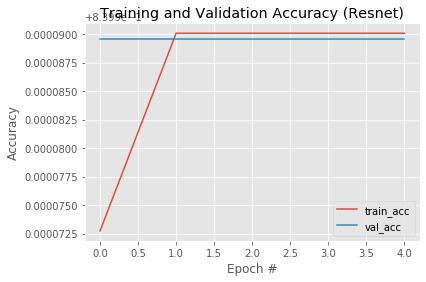

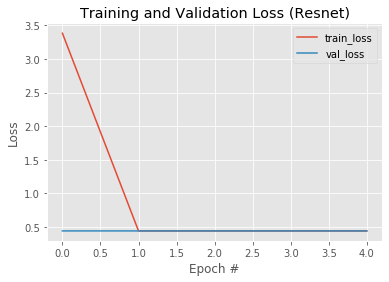

In [58]:
%matplotlib inline
import matplotlib.pyplot as plt

# 绘制结果曲线

N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["accuracy"], label="train_acc")
plt.plot(N, H.history["val_accuracy"], label="val_acc")
plt.title("Training and Validation Accuracy (Resnet)")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend()
plt.show()
# plt.savefig('./output/simple_nn_plot_acc.png')
 
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.title("Training and Validation Loss (Resnet)")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.show()
# plt.savefig('./output/simple_nn_plot_loss.png')

# 4 计算结果

In [25]:
# 恢复数据
test = read_param('test')

## 4.1 LGBM结果

In [7]:
sub['label'] = model_lgb.predict_proba(test[feature_cols])[:, 1]

In [8]:
sub.to_csv('./storage/result.txt', index=None, header=None, sep='\t')

## 4.2 神经网络结果

In [37]:
res = model.predict(test[feature_cols], batch_size=BATCH_SIZE)
res

array([[0.51117074],
       [0.51117074],
       [0.51117074],
       ...,
       [0.5111708 ],
       [0.5111708 ],
       [0.5111708 ]], dtype=float32)

In [87]:
test[feature_cols]

,freq,freq_count,gender,gender_count,hour,q_ans_count,q_diff_qa_days_max,q_diff_qa_days_mean,q_diff_qa_days_sum,q_has_img_max,...,uf_c2_count,uf_c3,uf_c3_count,uf_c4,uf_c4_count,uf_c5,uf_c5_count,uid_enc,uid_enc_count,wk
0,6,0.325453,4,0.0000,9,NaN,NaN,NaN,NaN,NaN,...,0.439214,203,0.479449,1376,0.000038,3,0.346068,1752473,0.000000,6
1,2,0.726702,4,0.0000,22,NaN,NaN,NaN,NaN,NaN,...,0.439214,396,0.456703,521,0.008534,3,0.346068,767938,0.000000,1
2,6,0.325453,2,0.4874,15,NaN,NaN,NaN,NaN,NaN,...,0.439214,205,0.083870,445,0.007599,3,0.346068,1147981,0.000009,3
3,5,1.000000,3,1.0000,4,4.0,11.0,3.0,12.0,0.0,...,0.439214,188,0.114102,1038,0.001950,2,1.000000,1372679,0.000015,2
4,6,0.325453,2,0.4874,19,NaN,NaN,NaN,NaN,NaN,...,0.168475,336,0.137013,788,0.001688,3,0.346068,1,0.297591,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1141678,6,0.325453,4,0.0000,20,NaN,NaN,NaN,NaN,NaN,...,0.168475,81,0.020067,760,0.434533,3,0.346068,504330,0.000000,5
1141679,3,0.118357,4,0.0000,21,NaN,NaN,NaN,NaN,NaN,...,0.439214,121,0.094249,760,0.434533,3,0.346068,1066119,0.000003,1
1141680,2,0.726702,4,0.0000,15,NaN,NaN,NaN,NaN,NaN,...,0.001308,313,0.056923,760,0.434533,3,0.346068,435862,0.000000,0
1141681,6,0.325453,4,0.0000,8,NaN,NaN,NaN,NaN,NaN,...,0.439214,8,0.442846,1375,0.031122,3,0.346068,1287652,0.000015,0
